# Genomic surveillance analysis in Germany

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


## Download data
### Map
With zip codes for geo matching

In [2]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

### Sequences
From RKI's Github

In [3]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   210  100   210    0     0    600      0 --:--:-- --:--:-- --:--:--   598
100 39.5M  100 39.5M    0     0  13.0M      0  0:00:03  0:00:03 --:--:-- 18.3M
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   216  100   216    0     0    631      0 --:--:-- --:--:-- --:--:--   629
100 15.5M  100 15.5M    0     0  2593k      0  0:00:06  0:00:06 --:--:-- 4491k
+ bash scripts/

In [4]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [5]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [6]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [7]:
df.reason.value_counts()

N                             336363
X                             240207
A[B.1.1.7]                     35832
A[B.1.617.2]                   35581
Y                              26380
                               ...  
A[KONTAKTMITENGL.MUTATION]         0
A[B1.627.2]                        0
A[E484E/N501N/P681R]               0
A[E484K/N501Y/P681R]               0
A[B1.1.529]                        0
Name: reason, Length: 210, dtype: int64

In [8]:
import re

In [9]:
df

date reason  \
IMS_ID                                                                 
IMS-10294-CVDP-00001                               2021-01-14      X   
IMS-10294-CVDP-00325                               2020-11-08      X   
IMS-10294-CVDP-00326                               2020-11-08      X   
IMS-10294-CVDP-00327                               2020-11-08      X   
IMS-10294-CVDP-00329                               2020-11-09      X   
...                                                       ...    ...   
IMS-10116-CVDP-FE1A432E-80D7-498C-B1F3-5997C95D... 2022-03-04      N   
IMS-10116-CVDP-99241F0D-8013-4406-89C5-720018EC... 2022-03-04      N   
IMS-10116-CVDP-8160CD80-D716-4D7E-9D03-7BEE3078... 2022-03-03      N   
IMS-10116-CVDP-C0C4DD90-BB68-4519-9248-E200CFF6... 2022-03-04      N   
IMS-10116-CVDP-8F4BD757-1E50-44CB-B49D-EC7409AB... 2022-03-05      N   

                                                   processing_date sending_pc  \
IMS_ID                                                                          
IMS-10294-CVDP-00001                                    2021-01-25      40225   
IMS-10294-CVDP-00325                                    2021-02-14      40225   
IMS-10294-CVDP-00326                                    2021-02-14      40225   
IMS-10294-CVDP-00327                                    2021-02-14      40225   
IMS-10294-CVDP-00329                                    2021-02-14      40225   
...                                                            ...        ...   
IMS-10116-CVDP-FE1A432E-80D7-498C-B1F3-5997C95D...      2022-03-20      37081   
IMS-10116-CVDP-99241F0D-8013-4406-89C5-720018EC...      2022-03-20      37081   
IMS-10116-CVDP-8160CD80-D716-4D7E-9D03-7BEE3078...      2022-03-20      37081   
IMS-10116-CVDP-C0C4DD90-BB68-4519-9248-E200CFF6...      2022-03-20      37081   
IMS-10116-CVDP-8F4BD757-1E50-44CB-B49D-EC7409AB...      2022-03-20      37081   

                                                   sequencing_pc    lineage  \
IMS_ID                                                                        
IMS-10294-CVDP-00001                                     40225.0  B.1.1.297   
IMS-10294-CVDP-00325                                     40225.0    B.1.221   
IMS-10294-CVDP-00326                                     40225.0    B.1.160   
IMS-10294-CVDP-00327                                     40225.0    B.1.258   
IMS-10294-CVDP-00329                                     40225.0  B.1.1.521   
...                                                          ...        ...   
IMS-10116-CVDP-FE1A432E-80D7-498C-B1F3-5997C95D...       69126.0       BA.2   
IMS-10116-CVDP-99241F0D-8013-4406-89C5-720018EC...       69126.0       BA.2   
IMS-10116-CVDP-8160CD80-D716-4D7E-9D03-7BEE3078...       69126.0       BA.2   
IMS-10116-CVDP-C0C4DD90-BB68-4519-9248-E200CFF6...       69126.0       BA.2   
IMS-10116-CVDP-8F4BD757-1E50-44CB-B49D-EC7409AB...       69126.0     BA.1.1   

                                                                scorpio  \
IMS_ID                                                                    
IMS-10294-CVDP-00001                                                NaN   
IMS-10294-CVDP-00325                                                NaN   
IMS-10294-CVDP-00326                                                NaN   
IMS-10294-CVDP-00327                                                NaN   
IMS-10294-CVDP-00329                                                NaN   
...                                                                 ...   
IMS-10116-CVDP-FE1A432E-80D7-498C-B1F3-5997C95D...  Omicron (BA.2-like)   
IMS-10116-CVDP-99241F0D-8013-4406-89C5-720018EC...  Omicron (BA.2-like)   
IMS-10116-CVDP-8160CD80-D716-4D7E-9D03-7BEE3078...  Omicron (BA.2-like)   
IMS-10116-CVDP-C0C4DD90-BB68-4519-9248-E200CFF6...  Omicron (BA.2-like)   
IMS-10116-CVDP-8F4BD757-1E50-44CB-B49D-EC7409AB...  Omicron (BA.1-like)   

                                                             b

In [10]:
df.lineage[df.date > np.datetime64("today") - np.timedelta64(30, "D")].cat.remove_unused_categories().value_counts()

BA.2          35705
BA.1.1        12325
BA.1           4396
None            485
B.1              89
B.1.177.86       10
BA.3              8
B.1.617.2         7
AY.121            4
AZ.2              4
B.1.2             3
B.1.1             3
AY.13             2
AY.127            2
AY.122            2
B.1.575.1         2
AY.129            1
AY.21             1
AY.4              1
AY.4.2.3          1
B.1.351           1
AY.121.1          1
AY.127.1          1
AY.43             1
Name: lineage, dtype: int64

In [11]:
import re

In [12]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.add_categories(['Other'])
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2']),"lineage"] = "Other"
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage.cat.remove_unused_categories(), dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[1,2,3,4,5,0]]
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland        date                                                  
Baden-Württemberg 2021-11-01     0       0     0     0      0        142
                  2021-11-02     0       0     0     0      0        350
                  2021-11-03     0       0     0     0      0        704
                  2021-11-04     0       0     0     0      0       1044
                  2021-11-05     0       0     0     0      0       1210
...                            ...     ...   ...   ...    ...        ...
Thüringen         2022-03-16     0       0     0     0      0          0
                  2022-03-17     0       0     0     0      0          0
                  2022-03-18     0       0     0     0      0          0
                  2022-03-19     0       0     0     0      0          0
                  2022-03-21     0       0     0     0      0          0

[2240 rows x 6 columns]

In [13]:
genomes.sum(level=0)

lineage                  BA.1  BA.1.1   BA.2  BA.3  Other  B.1.617.2
bundesland                                                          
Baden-Württemberg       17284   22366  18005     8     32      41417
Bayern                   3291    5516   7472     0     29       6228
Berlin                    739     782   1237     0      5       2888
Brandenburg               958    1466   1542     1      0       2851
Bremen                    209     396    110     0      5        837
Hamburg                  4054    3597   2236     3     23       3769
Hessen                   1022    1686    959     2      1       1643
Mecklenburg-Vorpommern    589     635    696     0      0       2825
Niedersachsen             987    1221    906     0      6       3018
Nordrhein-Westfalen     20202   22853  18113    17    163      26433
Rheinland-Pfalz           338     503    316     0      2       1511
Saarland                  821    1275    654     0      4       1777
Sachsen                  5278    7992   4413     2     32      15124
Sachsen-Anhalt           1745     705   1273     5      0       3003
Schleswig-Holstein       3400    4840   4088     4      2       3907
Thüringen                 358     717    424     0      8       1703

In [14]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [15]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

### Cases
Also from RKI

In [16]:
cases_raw = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [17]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-19   
                                    2020-03-13  2020-03-21   
            A35-A59      M          2020-03-16  2020-03-14   
            A15-A34      M          2020-03-16  2020-03-19   
...                                                    ...   
16077       A35-A59      W          2022-03-24  2022-03-24   
            A00-A04      W          2022-03-24  2022-03-24   
            A80+         W          2022-03-24  2022-03-24   
            A05-A14      W          2022-03-24  2022-03-24   
            A15-A34      W          2022-03-24  2022-03-24   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
            A35-A59      M          2020-03-16                     1   
            A15-A34      M          2020-03-16                     1   
...                                                              ...   
16077       A35-A59      W          2022-03-24                     0   
            A00-A04      W          2022-03-24                     0   
            A80+         W          2022-03-24                     0   
            A05-A14      W          2022-03-24                     0   
            A15-A34      W          2022-03-24                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
            A35-A59      M          2020-03-16          0              -9   
            A15-A34      M          2020-03-16          0              -9   
...                                                   ...             ...   
16077       A35-A59      W          2022-03-24          1              -9   
            A00-A04      W          2022-03-24          1              -9   
            A80+         W          2022-03-24          1              -9   
            A05-A14      W          2022-03-24          1              -9   
            A15-A34      W          2022-03-24          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
            A35-A59      M          2020-03-16           0           1   
            A15-A34      M          2020-03-16           0           1   
...                                                    ...         ...   
16077       A35-A59      W          2022-03-24          -9          74   
            A00-A04      W          2022-03-24          -9           4   
            A80+         W          2022-03-24          -9          11   
            A05-A14      W          2022-03-24          -9          21   
            A15-A34      W          2022-03-24          -9          41   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

### Registration delays

In [18]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-02-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

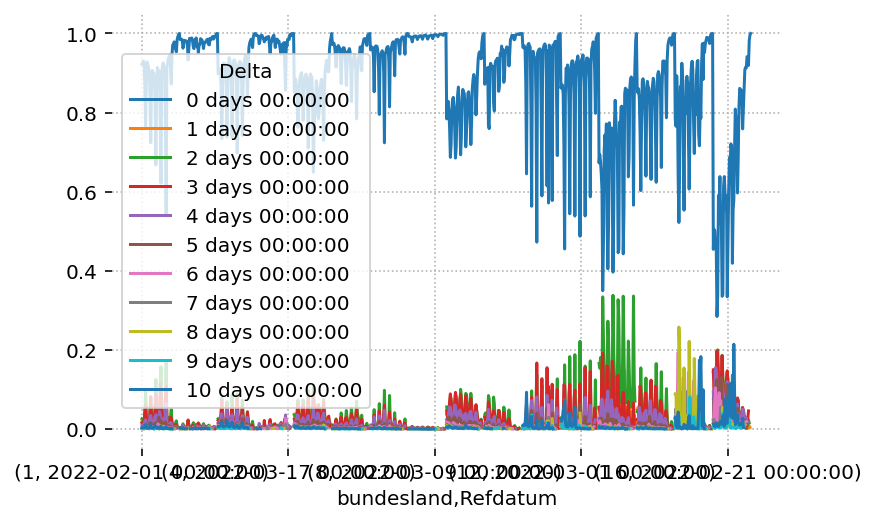

In [19]:
f.plot()

In [20]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [21]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [22]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Tue             0.934484         0.950761         0.973711         0.984785   
Wed             0.934873         0.953316         0.971338         0.980230   
Thu             0.935362         0.946820         0.960956         0.965730   
Fri             0.919682         0.931322         0.940431         0.963282   
Sat             0.846194         0.856047         0.900184         0.954185   
Sun             0.734241         0.778989         0.878648         0.943794   
Mon             0.908143         0.931823         0.962380         0.980625   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Tue             0.989535         0.990804         0.994620         0.996692   
Wed             0.982735         0.990223         0.995271         0.997321   
Thu             0.980130         0.991623         0.995844         0.997108   
Fri             0.982874         0.991571         0.994717         0.995898   
Sat             0.980094         0.989160         0.991706         0.991534   
Sun             0.972216         0.980167         0.984169         0.985733   
Mon             0.988373         0.991291         0.992580         0.995259   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Tue             0.997738         0.998349               1.0  
Wed             0.998345         0.998510               1.0  
Thu             0.998006         0.998316               1.0  
Fri             0.996732         0.996304               1.0  
Sat             0.994213         0.995304               1.0  
Sun             0.990826         0.993290               1.0  
Mon             0.996949         0.998193               1.0

In [23]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [24]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [25]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.999862  0.999818  0.999611  0.999308  0.998373   
Bayern                  0.997480  0.995974  0.991743  0.983926  0.965429   
Berlin                  0.996590  0.996006  0.993573  0.975971  0.908868   
Brandenburg             0.993118  0.991425  0.988298  0.973578  0.925734   
Bremen                  0.999773  0.999720  0.999314  0.993858  0.986683   
Hamburg                 0.999285  0.998828  0.998565  0.996067  0.993820   
Hessen                  0.999404  0.999028  0.998547  0.997064  0.990986   
Mecklenburg-Vorpommern  0.998693  0.996968  0.995509  0.992102  0.973722   
Niedersachsen           0.995519  0.993362  0.990001  0.980145  0.950408   
Nordrhein-Westfalen     0.997444  0.996497  0.992708  0.987337  0.969684   
Rheinland-Pfalz         0.999281  0.998732  0.997680  0.994115  0.981171   
Saarland                0.998731  0.998556  0.998296  0.997509  0.987481   
Sachsen                 0.998985  0.998253  0.996835  0.993221  0.983041   
Sachsen-Anhalt          0.986681  0.994572  0.968481  0.874124  0.791040   
Schleswig-Holstein      0.998345  0.997108  0.994717  0.989160  0.972216   
Thüringen               0.968535  0.957011  0.961121  0.944593  0.854422   

                               5         6         7         8  
Baden-Württemberg       0.997989  0.997598  0.996517  0.995735  
Bayern                  0.941839  0.923407  0.904170  0.885120  
Berlin                  0.985787  0.951807  0.974833  0.969508  
Brandenburg             0.973367  0.966263  0.947948  0.940553  
Bremen                  0.991136  0.989166  0.990188  0.987889  
Hamburg                 0.994806  0.990027  0.987941  0.985345  
Hessen                  0.989970  0.985487  0.977205  0.968472  
Mecklenburg-Vorpommern  0.963663  0.945968  0.856679  0.807344  
Niedersachsen           0.959671  0.962458  0.952009  0.943881  
Nordrhein-Westfalen     0.963527  0.947481  0.928123  0.908165  
Rheinland-Pfalz         0.990306  0.984507  0.978567  0.976068  
Saarland                0.976689  0.974406  0.962592  0.959004  
Sachsen                 0.978750  0.970590  0.943069  0.911214  
Sachsen-Anhalt          0.872319  0.877600  0.908327  0.941331  
Schleswig-Holstein      0.980625  0.973711  0.953316  0.935362  
Thüringen               0.850109  0.812860  0.780700  0.748552

In [26]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [27]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,"2021-11-01":,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2145        2955        4425        4623   
Bayern                        5956        7034        9179        8949   
Berlin                        1325        1322        1440        1433   
Brandenburg                    814         983        1073        1055   
Bremen                          79          89          69          62   
Hamburg                        320         457         540         502   
Hessen                        1193        1595        1705        1574   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1186        1453        1673        1370   
Nordrhein-Westfalen           2558        3458        4355        4359   
Rheinland-Pfalz                642         990        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2840        3670        3476        3313   
Sachsen-Anhalt                 647         855         721         738   
Schleswig-Holstein             336         389         367         354   
Thüringen                     1823        1430        1426        1502   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5068        4128        2276        4390   
Bayern                        9248        8801        7234        9333   
Berlin                        1451         968         753        2176   
Brandenburg                   1184        1118         980        1261   
Bremen                          55          55          31          60   
Hamburg                        556         471         412         481   
Hessen                        1689        1313        1092        1468   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1401        1164         844        1621   
Nordrhein-Westfalen           4065        3721        2965        4419   
Rheinland-Pfalz               1027         808         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3467        3192        2666        4438   
Sachsen-Anhalt                 729         658         899         670   
Schleswig-Holstein             435         382         298         449   
Thüringen                     1429        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-03-15  2022-03-16  \
bundesland                                      ...                           
Baden-Württemberg             7122        7755  ...       42264       42138   
Bayern                       11243       12158  ...       48277       56490   
Berlin                        1921        2398  ...        8714        9098   
Brandenburg                   1496        1688  ...        8216        8470   
Bremen                         143          95  ...        1612        1819   
Hamburg                        530         569  ...        3984        4474   
Hessen                        1791        2067  ...       13648       16684   
Mecklenburg-Vorpommern         597         468  ...        8673        7838   
Niedersachsen                 1754        2165  ...       27183       29554   
Nordrhein-Westfalen           5142        5313  ...       50555       52207   
Rheinland-Pfalz               1139        1329  ...       12957       14279   
Saarland                       273         301  ...        4344        4299   
Sachsen                       5757        5988  ...       18665       19530   
Sachsen-Anhalt                1019        1178  ...        7578        8804   
Schleswig-Holstein             486         542  ...        9082       

In [28]:
cases_land.sum(0)

Refdatum
2021-11-01     22409
2021-11-02     27231
2021-11-03     32184
2021-11-04     31460
2021-11-05     32533
               ...  
2022-03-20     84943
2022-03-21    219544
2022-03-22    274328
2022-03-23    268625
2022-03-24    195090
Length: 144, dtype: int64

In [29]:
clip = 1
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2145        2955        4425        4623   
Bayern                        5956        7034        9179        8949   
Berlin                        1325        1322        1440        1433   
Brandenburg                    814         983        1073        1055   
Bremen                          79          89          69          62   
Hamburg                        320         457         540         502   
Hessen                        1193        1595        1705        1574   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1186        1453        1673        1370   
Nordrhein-Westfalen           2558        3458        4355        4359   
Rheinland-Pfalz                642         990        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2840        3670        3476        3313   
Sachsen-Anhalt                 647         855         721         738   
Schleswig-Holstein             336         389         367         354   
Thüringen                     1823        1430        1426        1502   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5068        4128        2276        4390   
Bayern                        9248        8801        7234        9333   
Berlin                        1451         968         753        2176   
Brandenburg                   1184        1118         980        1261   
Bremen                          55          55          31          60   
Hamburg                        556         471         412         481   
Hessen                        1689        1313        1092        1468   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1401        1164         844        1621   
Nordrhein-Westfalen           4065        3721        2965        4419   
Rheinland-Pfalz               1027         808         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3467        3192        2666        4438   
Sachsen-Anhalt                 729         658         899         670   
Schleswig-Holstein             435         382         298         449   
Thüringen                     1429        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-03-14  2022-03-15  \
bundesland                                      ...                           
Baden-Württemberg             7122        7755  ...       29561       42264   
Bayern                       11243       12158  ...       34879       48277   
Berlin                        1921        2398  ...        9566        8714   
Brandenburg                   1496        1688  ...        6233        8216   
Bremen                         143          95  ...        1860        1612   
Hamburg                        530         569  ...        3825        3984   
Hessen                        1791        2067  ...       12246       13648   
Mecklenburg-Vorpommern         597         468  ...        4829        8673   
Niedersachsen                 1754        2165  ...       16127       27183   
Nordrhein-Westfalen           5142        5313  ...       40196       50555   
Rheinland-Pfalz               1139        1329  ...       11974       12957   
Saarland                       273         301  ...        2070        4344   
Sachsen                       5757        5988  ...       14939       18665   
Sachsen-Anhalt                1019        1178  ...        5735        7578   
Schleswig-Holstein             486         542  ...        6920       

In [30]:
C = cases_land.values

### Population data
From Destatis

In [31]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [32]:
131 % 10

1

## Modeling
### Basis functions

In [33]:
from genomicsurveillance.misc import fused_basis
n = C.shape[1]+clip
#B0 = fused_basis(n, inc=10, fuse=4, pad=28 - n % 10) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 
B0 = fused_basis(n+2, inc=7, fuse=5, pad=30 - n % 7)## cubic spline basis every 7d, last 5 linearly fused to avoid wriggles 
B0 = np.stack([B0[0,2:,:],B0[1,:-2,:]])

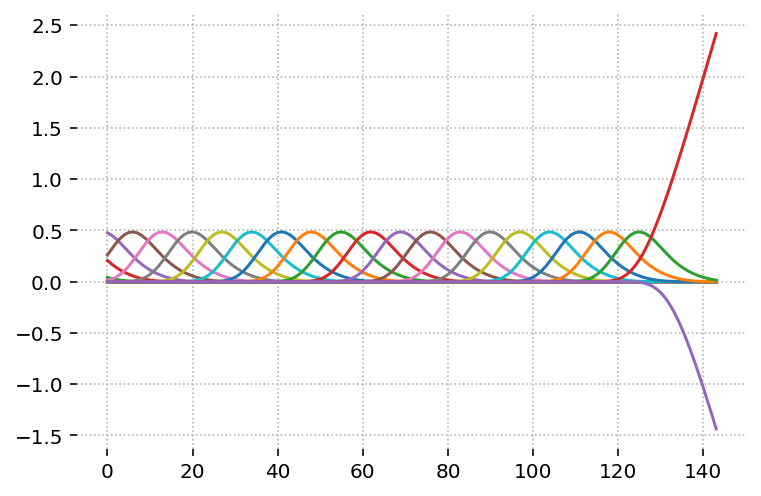

In [34]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

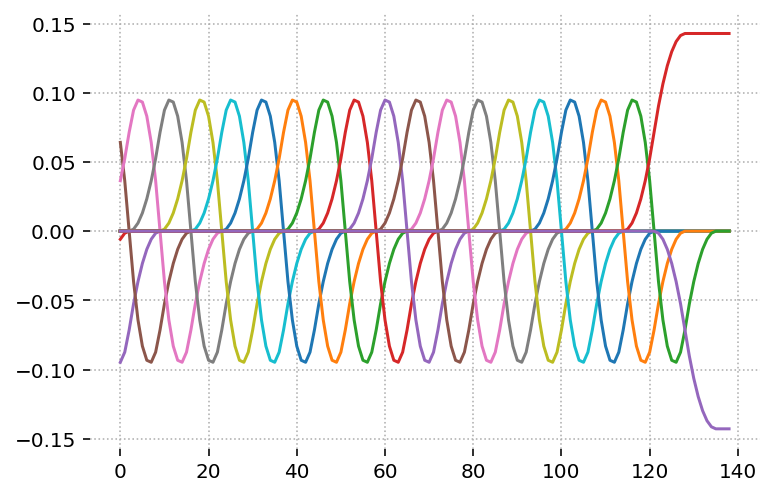

In [35]:
for i in range(B0.shape[-1]):
    plt.plot(B0[1,:-5,i])

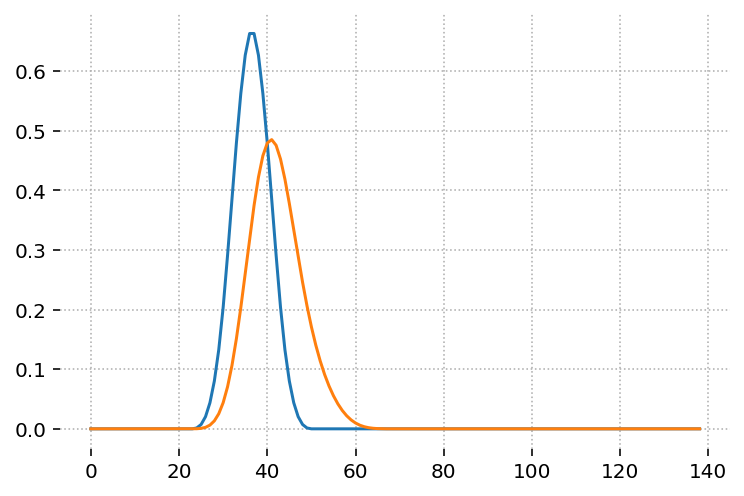

In [36]:
plt.plot(B0[1,:-5,10].cumsum())
plt.plot(B0[0,:-5,10])


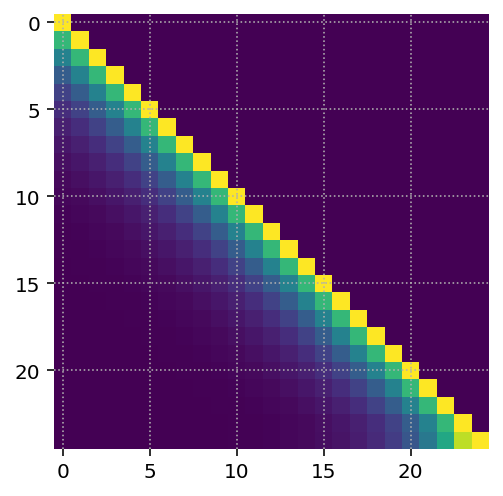

In [37]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.667
arma2[-1,-2] = -.9
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

### Case and genome data
Prepare as arrays and add Germany as a whole

In [38]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [39]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [40]:
from numpyro.infer import Trace_ELBO

In [41]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

In [42]:
CC[2,cases_land.columns == np.datetime64("2022-03-08")] = np.nan # int women's day in Berlin..

### Model
Multi-lineage model with variable growth rates (random effect) across states

In [43]:
model = MultiLineageTimeShift(
    CC,
    GG,    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)]),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.01,
    b0_scale=0.3,
    c_scale=20,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=100., 
    week=True,
    fit_logits=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [44]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

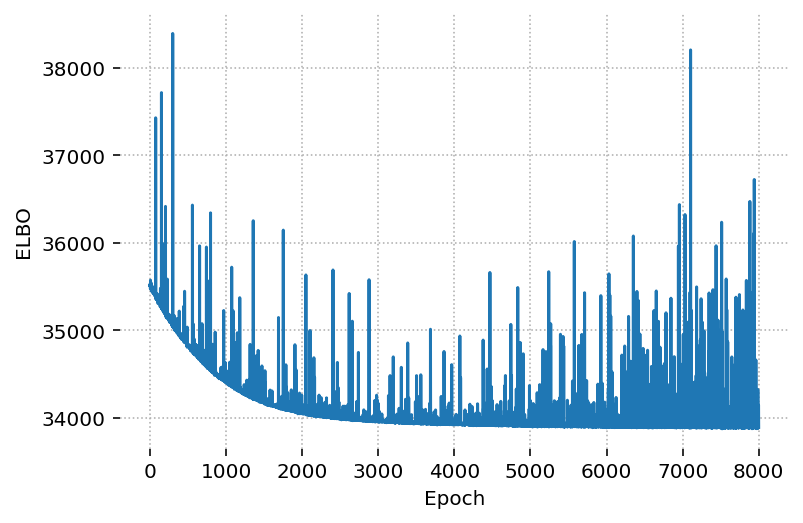

In [45]:
plt.plot(model.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((None, model.loss[2000]))

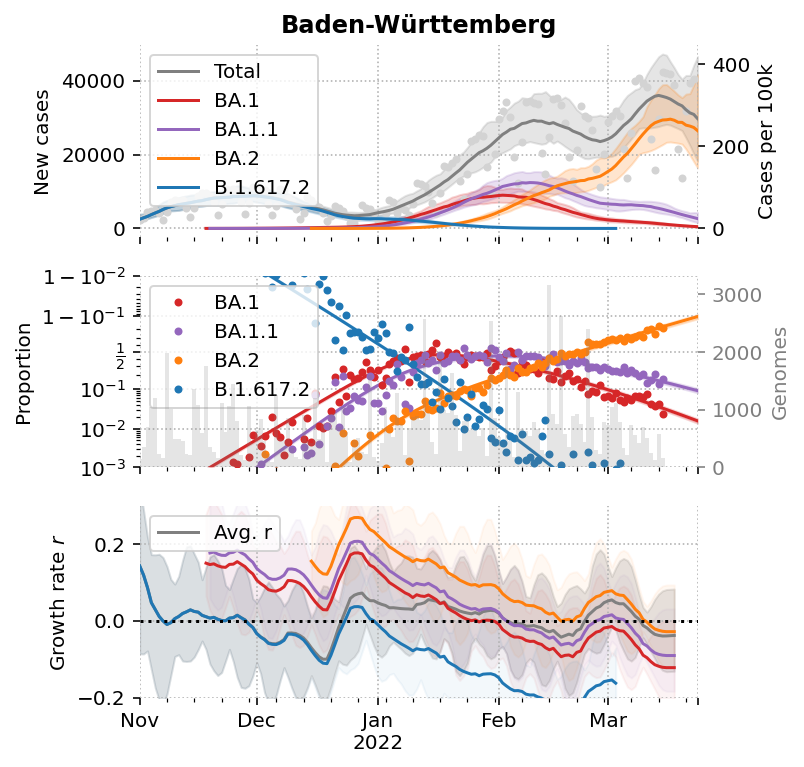

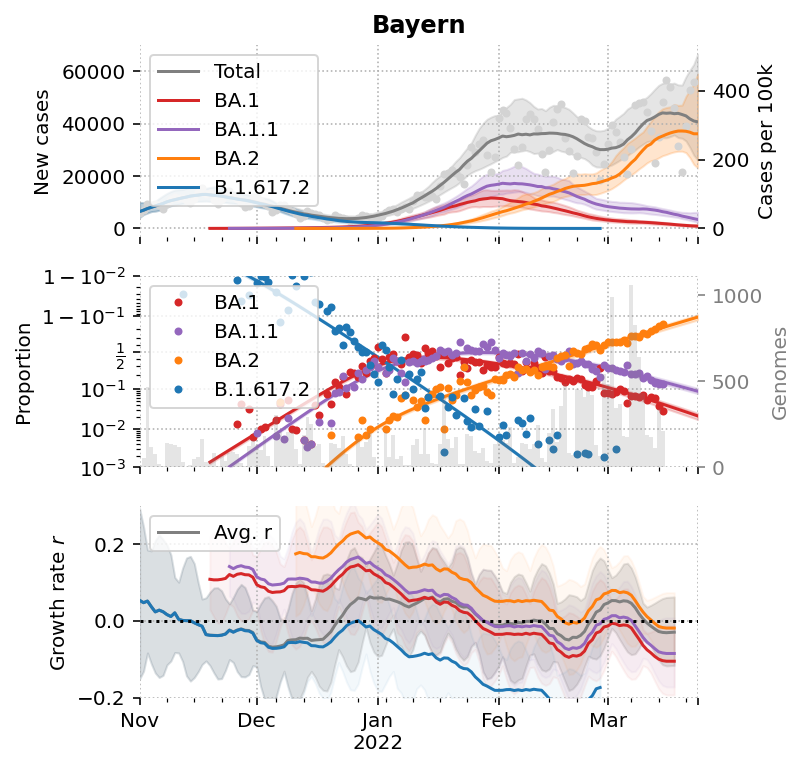

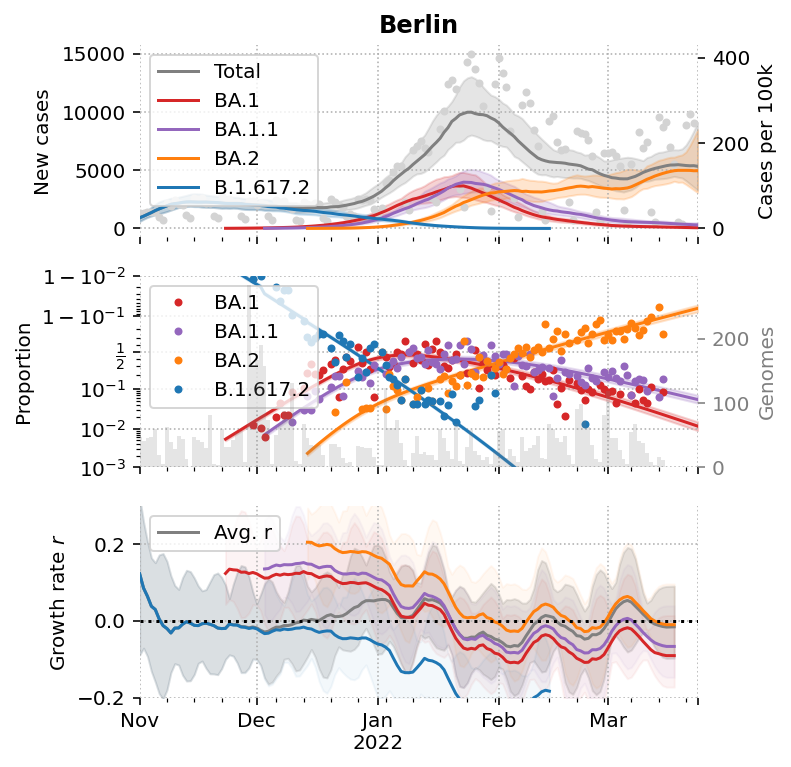

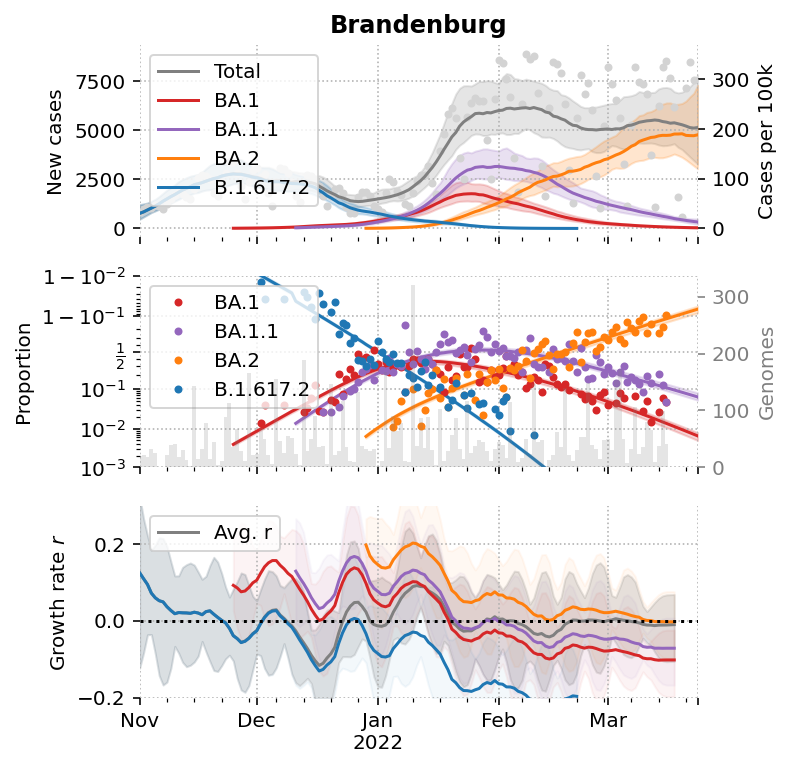

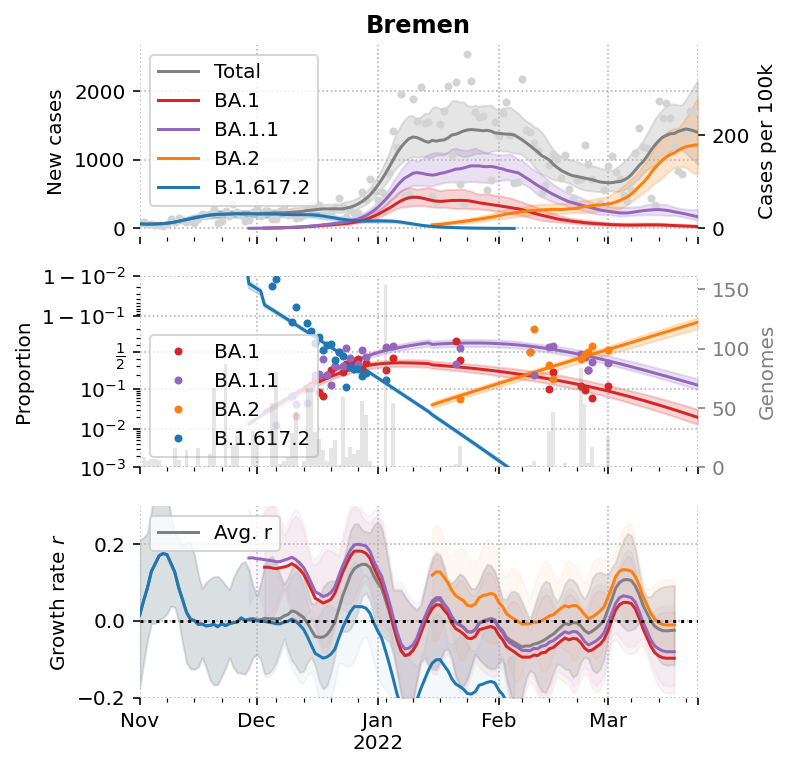

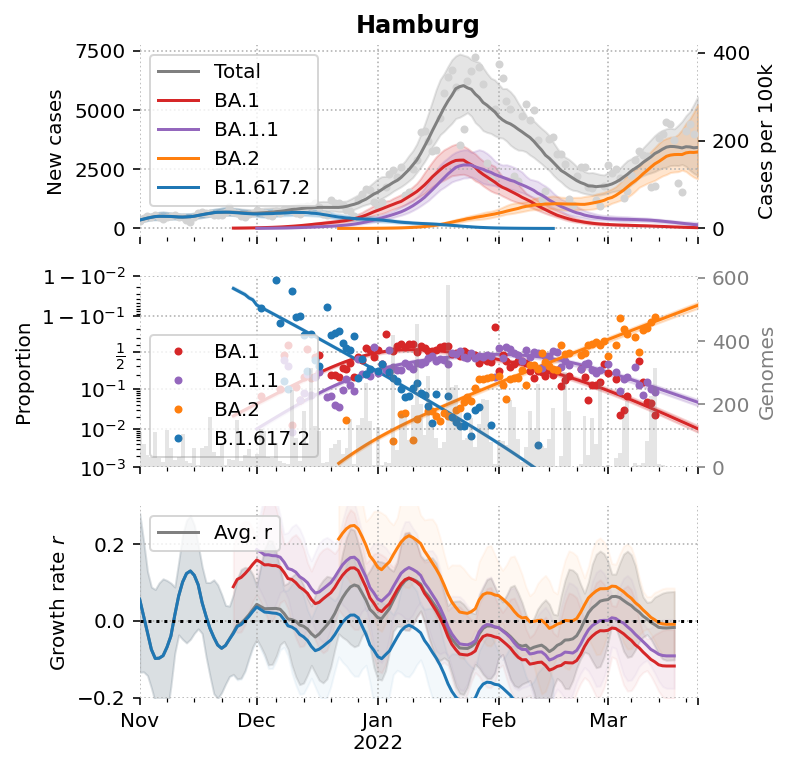

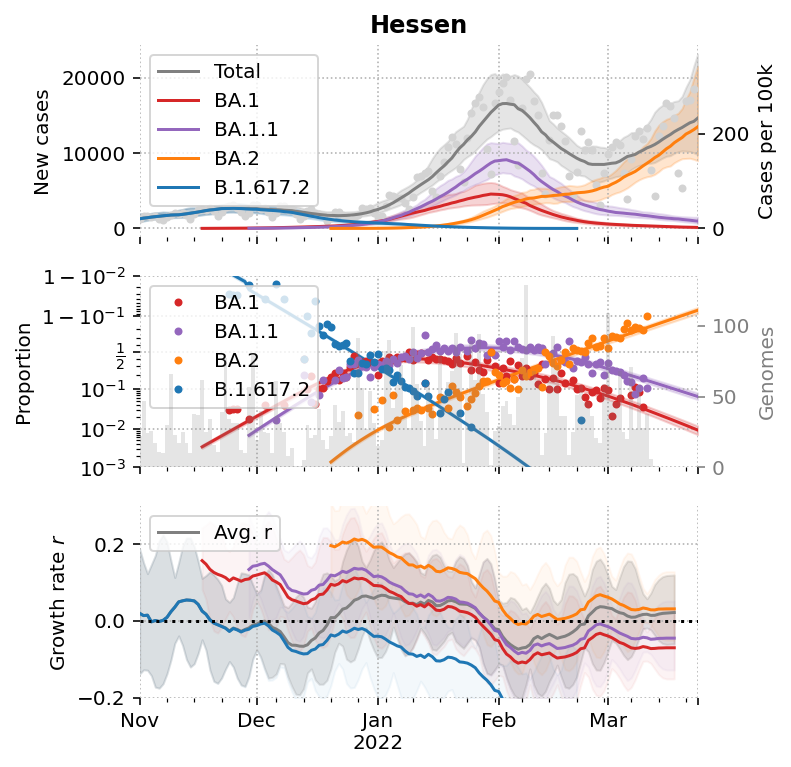

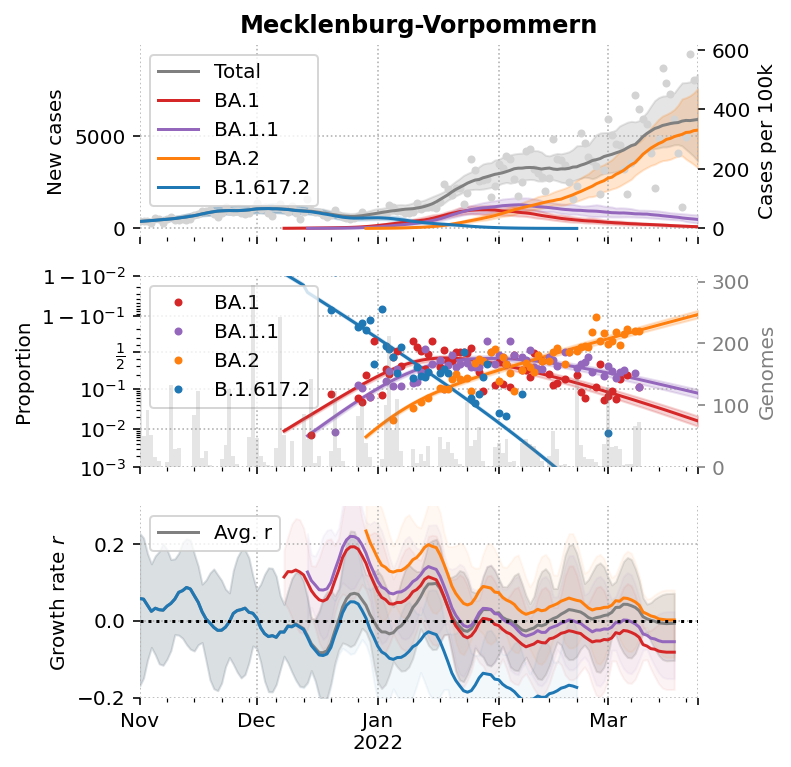

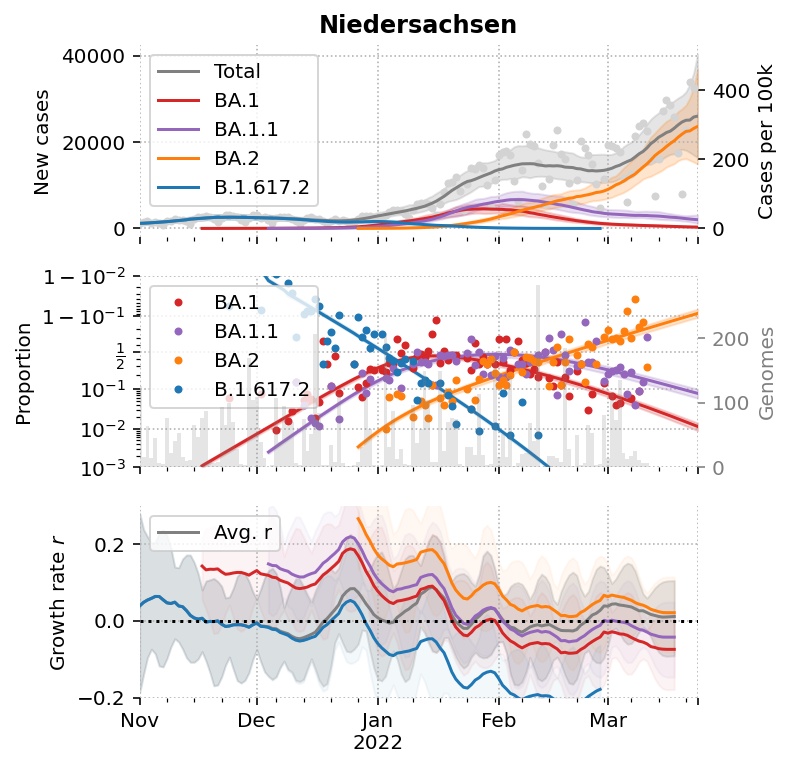

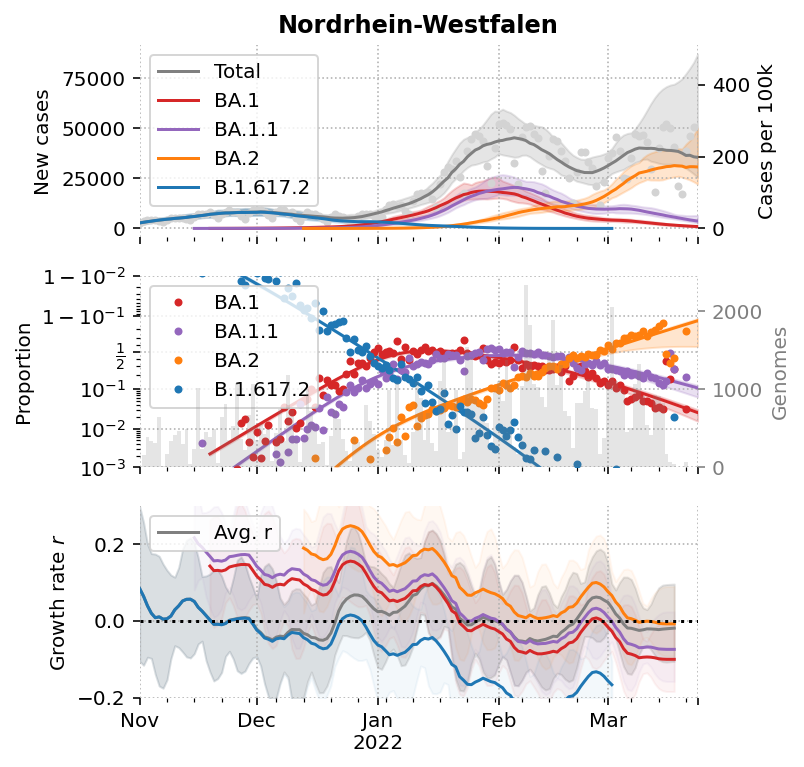

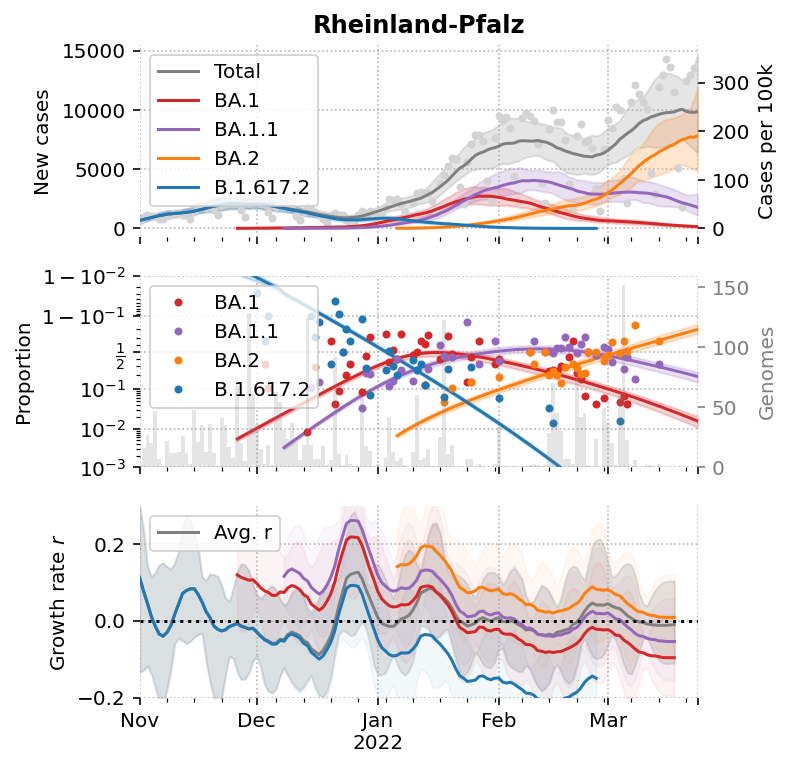

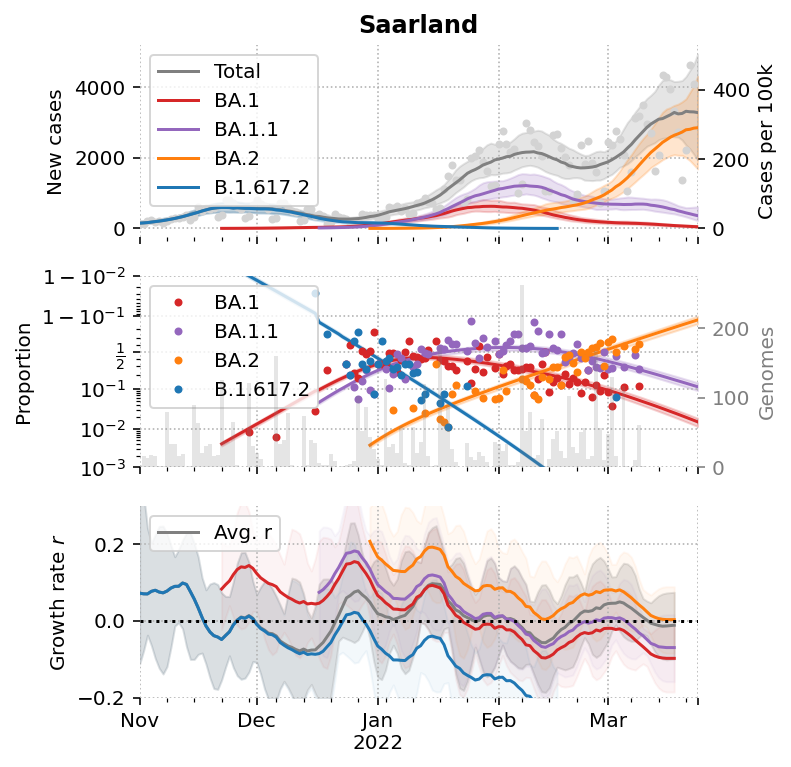

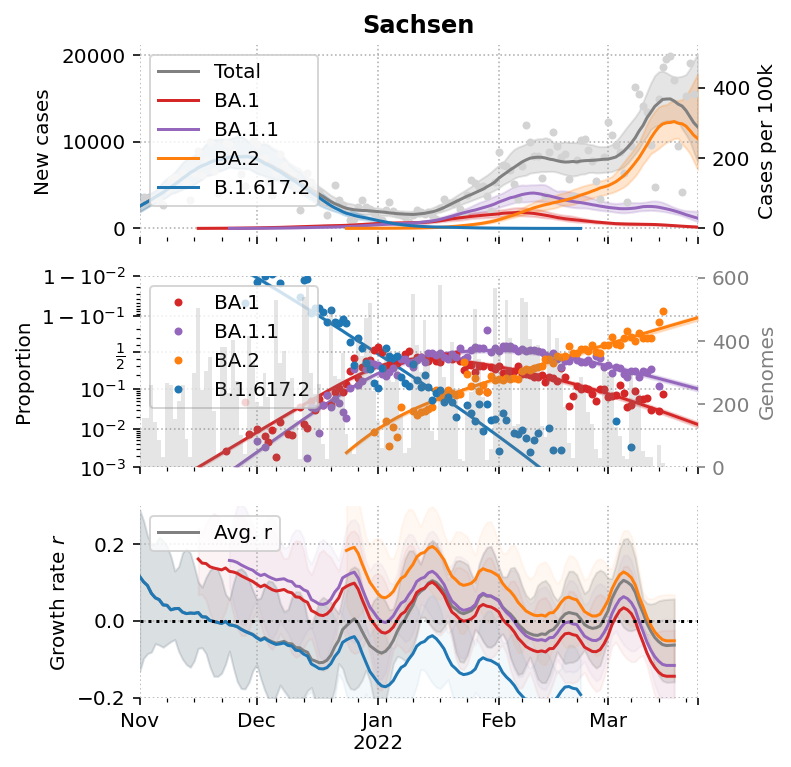

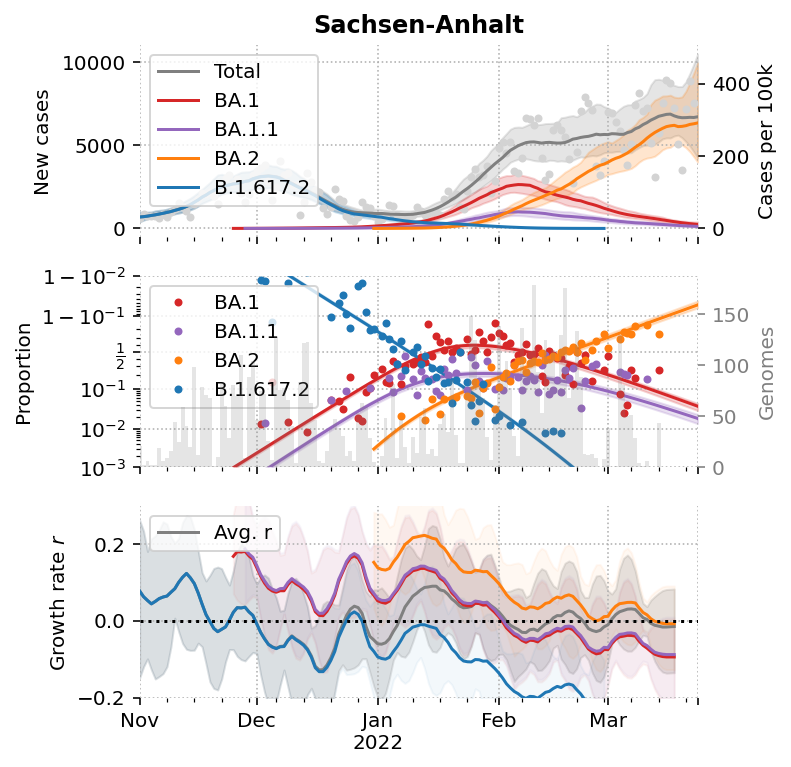

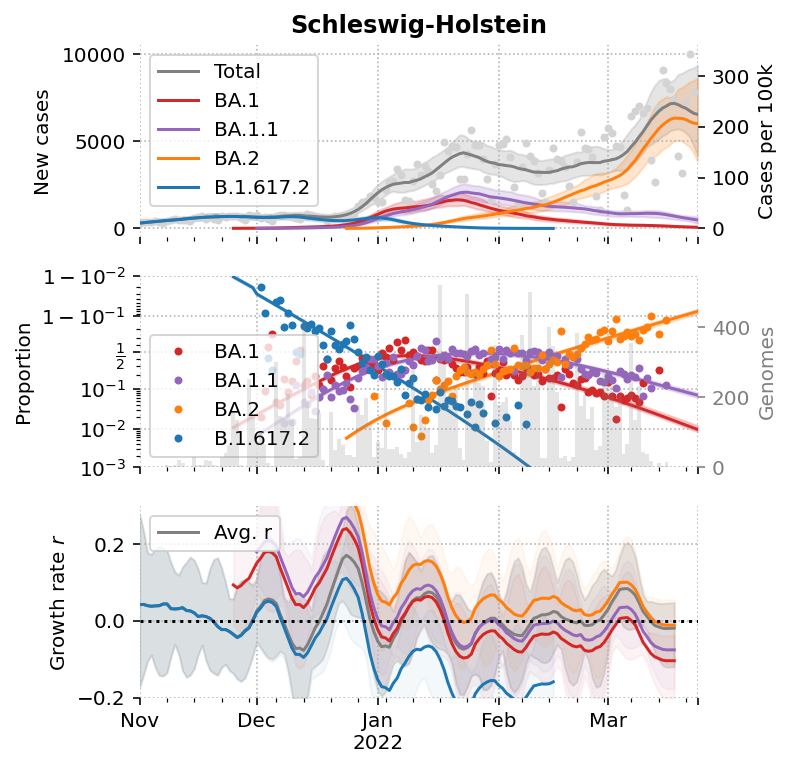

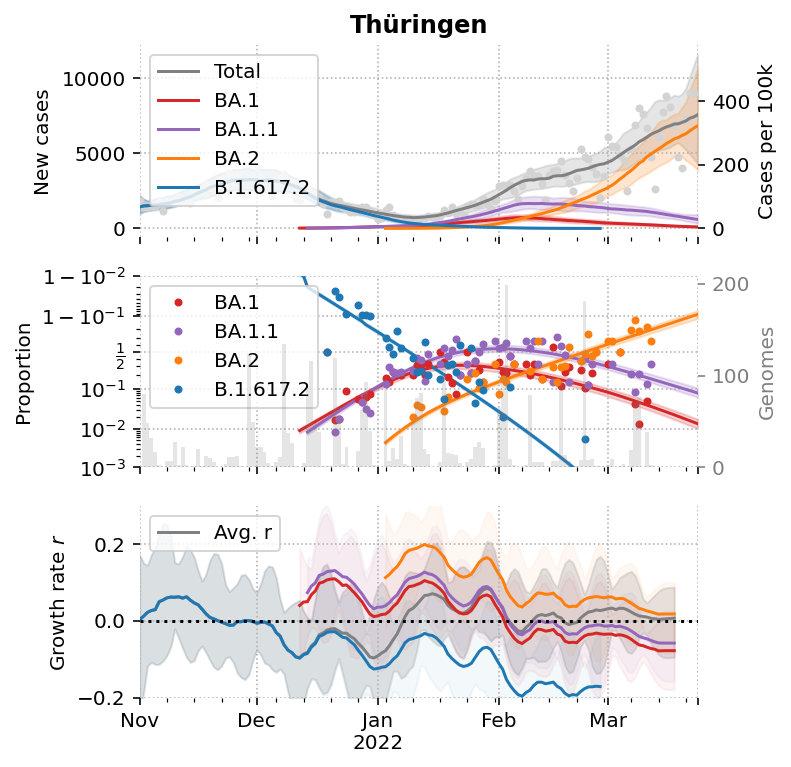

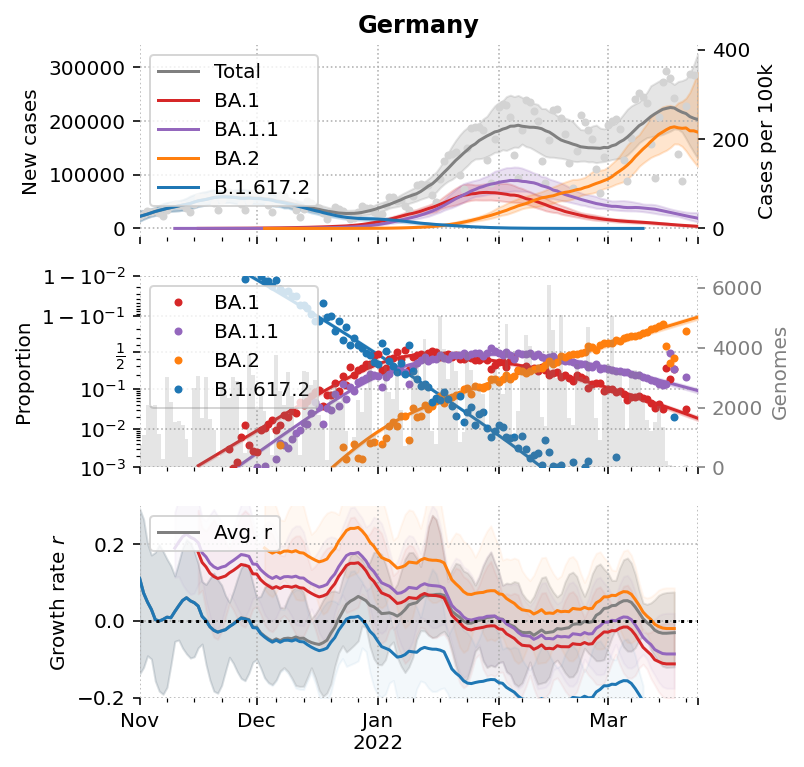

In [46]:
#from genomicsurveillance.plots.england import plot_lad, 
from genomicsurveillance.plots.england import plot_median_and_ci
for i,r in enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 1)[0]
    w = list(set(w) - set([3,4]))
    plot_lad(model, i, CC, GG, seq_index, start_date="2021-11-01", show_start_date="2021-11-01",
        lin = w,
        labels = genomes.columns[w],
        lin_colors=np.array(['C3',"C4","C1", "C6","C5" ,"C0", "C9","C0"])[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
            figsize=(5,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    #ax[0].set_yscale('log')
    #ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-3,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")

In [47]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

1.0000000000000002

In [48]:
model.posterior.keys()

dict_keys(['b1', 'b_scale_lin', 'bc0', 'beta1', 'c1', 't', 'b0'])

Text(0.5, 1.0, 'Germany')

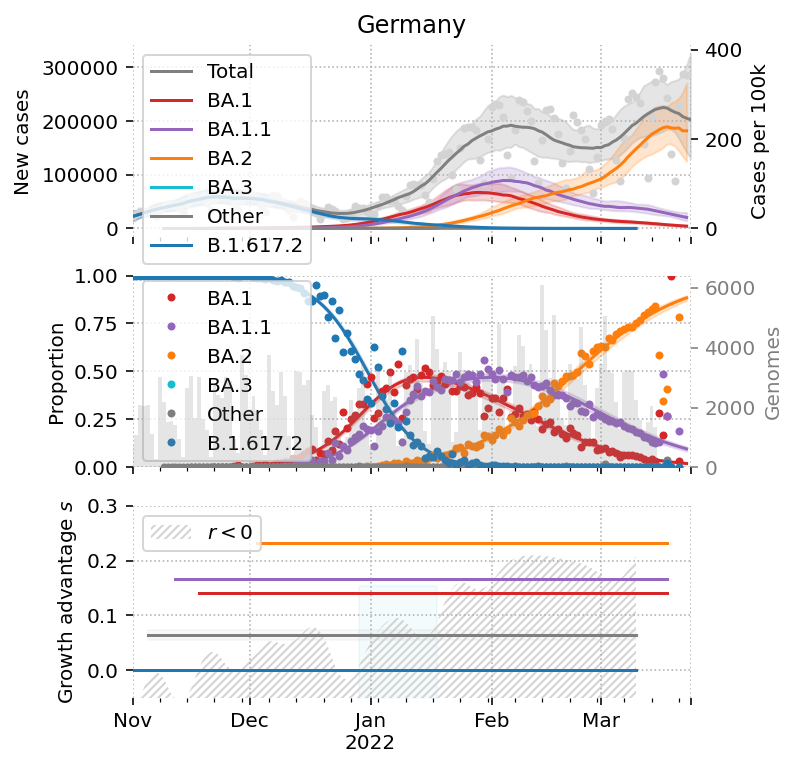

In [49]:
w = np.arange(genomes.shape[-1])
plot_lad(model, -1, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
            bleed_left = 1,
             bleed_right=6,
             show_Rt = False,
             plot_s= True
            )
plt.gcf().get_axes()[2].set_ylim(-0.05,0.3)
plt.gcf().get_axes()[0].set_title("Germany")

In [50]:
λ = model.get_lambda_lineage().mean(0) / model.population[:,np.newaxis, np.newaxis]

In [51]:
λ.shape

(17, 144, 6)

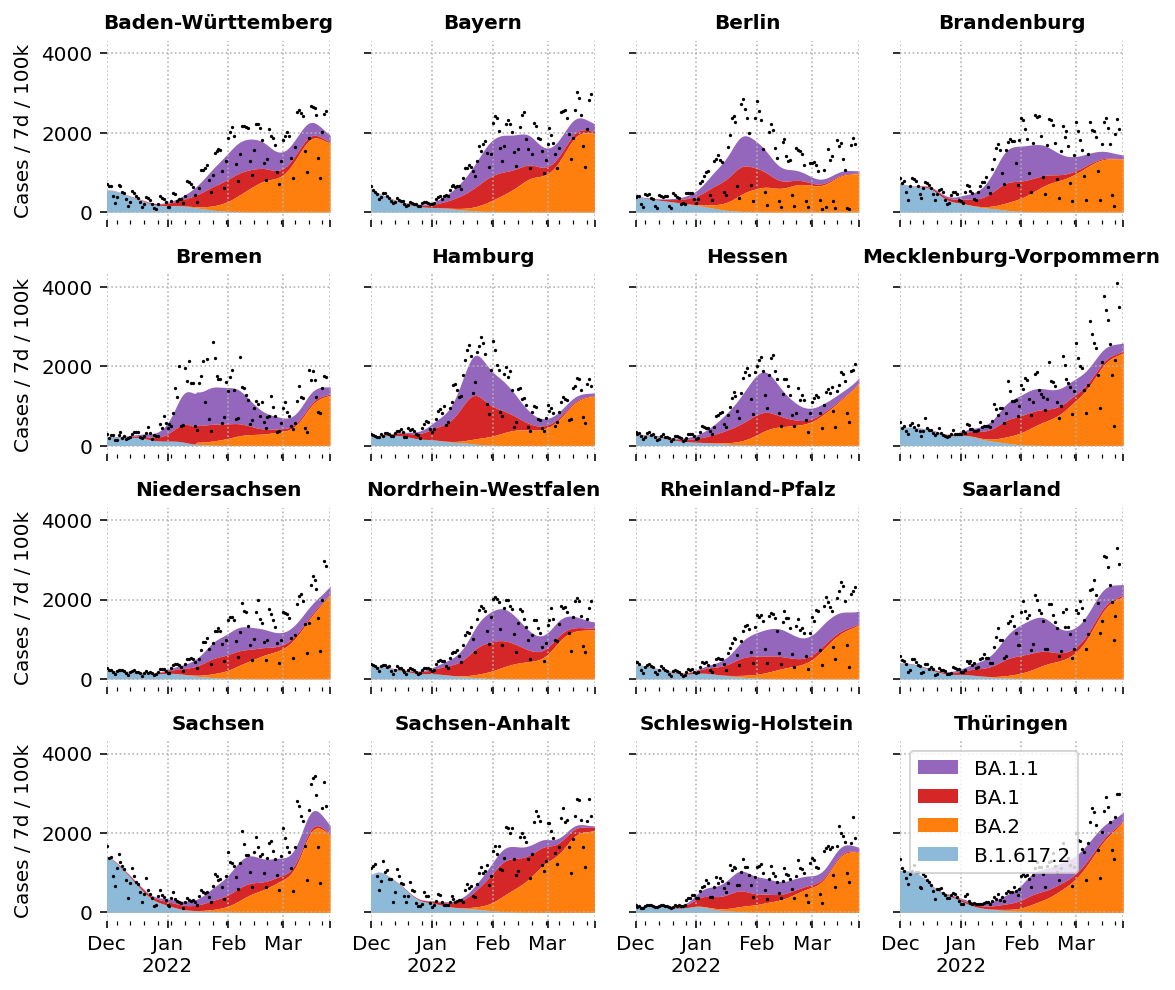

In [52]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(cases_land.index):
    y = pd.DataFrame(λ[i,:,:], columns=genomes.columns, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = y[["B.1.617.2","BA.2","BA.1","BA.1.1","BA.3"]].cumsum(1) * 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    (cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    ax[i].fill_between(y.index, y["BA.1"], y["BA.1.1"], color='C4', alpha=1, lw=0, label="BA.1.1")
    ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    ax[i].set_xlim(("2021-12-01",None))
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [53]:
λ[-1,-1] / λ[-1,-1].sum()

array([1.86750268e-02, 9.04293683e-02, 8.90887372e-01, 7.21886390e-06,
       7.37827805e-07, 2.75682362e-07])

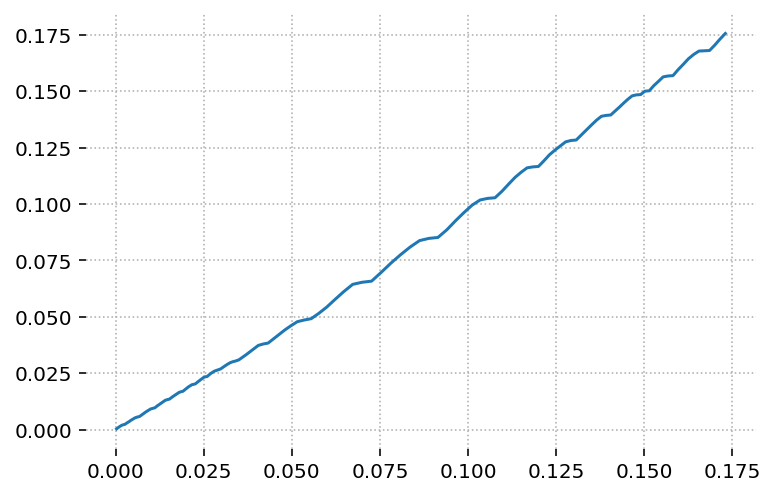

In [54]:
plt.plot(λ[2].sum(1).cumsum()[:-1], cases_land.loc['Berlin'].cumsum() / capita[2])

In [55]:
from genomicsurveillance.misc import get_transmissibility

In [56]:
pd.DataFrame(get_transmissibility(model), columns=genomes.columns, index=cases_land.index.to_list() + ["Germany"])

lineage                     BA.1    BA.1.1      BA.2      BA.3     Other  \
Baden-Württemberg       0.139634  0.169945  0.232450 -0.059153  0.014828   
Bayern                  0.145781  0.165802  0.232071 -0.035965  0.060152   
Berlin                  0.143873  0.168380  0.224958 -0.035965  0.021848   
Brandenburg             0.131751  0.162037  0.231767 -0.057908  0.039959   
Bremen                  0.143468  0.161386  0.229439 -0.035965  0.060616   
Hamburg                 0.122879  0.149673  0.232479 -0.056042  0.059938   
Hessen                  0.131561  0.156458  0.232453 -0.057760  0.018596   
Mecklenburg-Vorpommern  0.142600  0.169939  0.226843 -0.035965  0.039959   
Niedersachsen           0.136081  0.166725  0.232115 -0.035965  0.040833   
Nordrhein-Westfalen     0.140065  0.165825  0.232561 -0.059303  0.044690   
Rheinland-Pfalz         0.126773  0.169311  0.231478 -0.035965  0.017366   
Saarland                0.131918  0.160186  0.232473 -0.035965  0.015413   
Sachsen                 0.139329  0.167944  0.232483 -0.058149  0.065243   
Sachsen-Anhalt          0.146084  0.151855  0.232453 -0.054694  0.039959   
Schleswig-Holstein      0.129779  0.158256  0.222843 -0.058879  0.017340   
Thüringen               0.137137  0.158790  0.232371 -0.035965  0.020318   
Germany                 0.140047  0.165938  0.231962 -0.044643  0.065024   

lineage                 B.1.617.2  
Baden-Württemberg             0.0  
Bayern                        0.0  
Berlin                        0.0  
Brandenburg                   0.0  
Bremen                        0.0  
Hamburg                       0.0  
Hessen                        0.0  
Mecklenburg-Vorpommern        0.0  
Niedersachsen                 0.0  
Nordrhein-Westfalen           0.0  
Rheinland-Pfalz               0.0  
Saarland                      0.0  
Sachsen                       0.0  
Sachsen-Anhalt                0.0  
Schleswig-Holstein            0.0  
Thüringen                     0.0  
Germany                       0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1       122550                   0.065896  0.006660   
BA.1.1     153100                   0.081370  0.006069   
BA.2       124888                   0.142649  0.002940   
BA.3           84                  -0.035965  0.034223   
Other         624                   0.039959  0.020833   
B.1.617.2  237868                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.006660  
BA.1.1                           0.025864  0.006069  
BA.2                             0.093791  0.002940  
BA.3                            -0.193267  0.034223  
Other                           -0.099685  0.020833  
B.1.617.2                       -0.136986  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:917: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


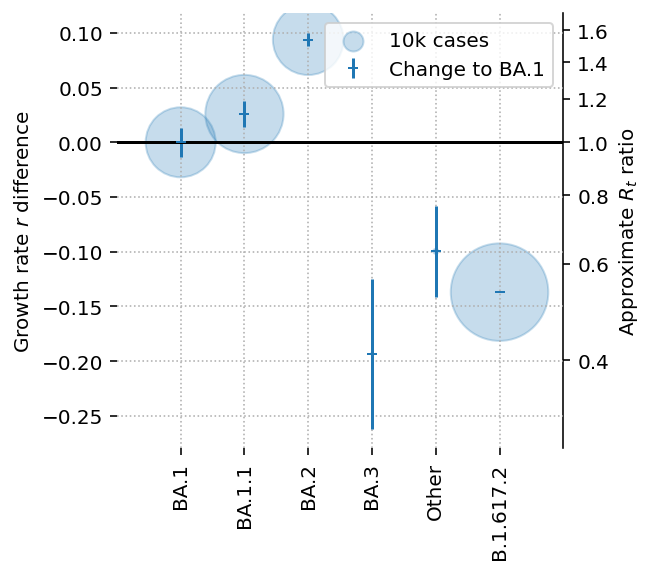

In [57]:
plt.figure(figsize=(4,4))
plot_growth_rates(model, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")

In [58]:
import geopandas as gpd

In [59]:
bl = gpd.read_file("data/bundeslaender.geojson").set_index("bundesland")

In [60]:
bl

land  \
bundesland                            
Baden-Württemberg       Deutschland   
Bayern                  Deutschland   
Berlin                  Deutschland   
Brandenburg             Deutschland   
Bremen                  Deutschland   
Hamburg                 Deutschland   
Hessen                  Deutschland   
Mecklenburg-Vorpommern  Deutschland   
Niedersachsen           Deutschland   
Nordrhein-Westfalen     Deutschland   
Rheinland-Pfalz         Deutschland   
Saarland                Deutschland   
Sachsen                 Deutschland   
Sachsen-Anhalt          Deutschland   
Schleswig-Holstein      Deutschland   
Thüringen               Deutschland   

                                                                 geometry  
bundesland                                                                 
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...  
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...  
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...  
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...  
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...  
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...  
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...  
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...  
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...  
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...  
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...  
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...  
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...  
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...  
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...  
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...

In [61]:
λ.sum(0)[-1] / λ.sum((0,2))[-1]

array([1.53372913e-02, 8.08518499e-02, 8.46309543e-01, 5.74970889e-02,
       3.81988681e-06, 4.07367589e-07])

In [62]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


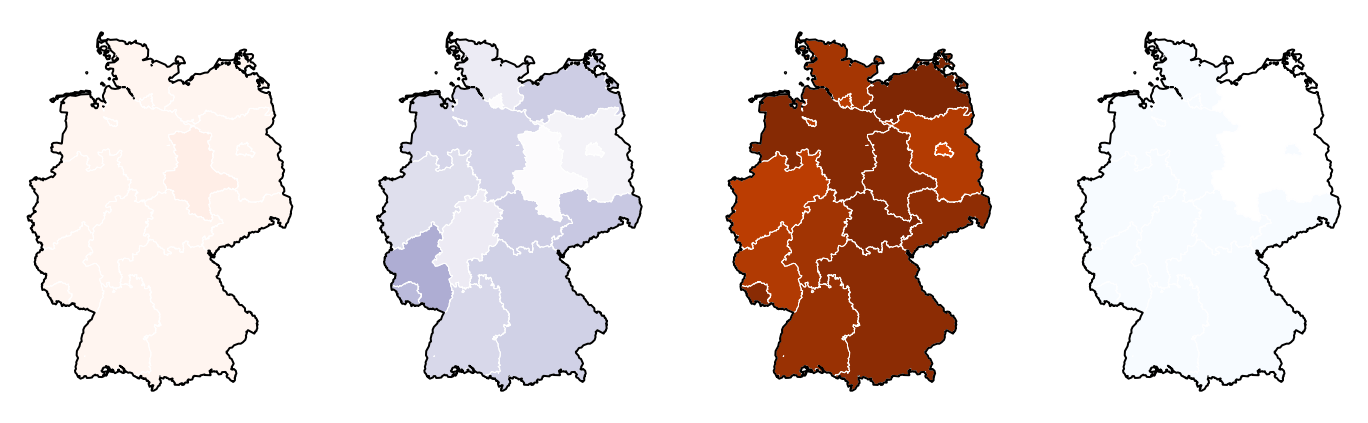

In [63]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,4, figsize=(12,6))
for ax in axs:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
b0 = bl.copy().merge(pd.DataFrame(λ[:-1,-1,:], columns=genomes.columns, index=bl.index), 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="Reds", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="Purples", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="Oranges",norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="Blues",norm=LogNorm(vmin=vmin, vmax=vmax))
for ax in axs:
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [64]:
b0.iloc[:,2:] * capita.values.reshape(-1,1)

BA.1       BA.1.1          BA.2          BA.3  \
bundesland                                                                    
Baden-Württemberg       485.325512  2774.843561  27461.756519      0.001303   
Bayern                  889.875512  3667.384167  37221.650630      0.000000   
Berlin                   64.183947   304.269794   5084.007028      0.000000   
Brandenburg              33.846699   332.709563   4851.561898      0.214217   
Bremen                   28.839875   178.627602   1230.224162      0.000000   
Hamburg                  35.368280   165.366397   3310.477009      0.036470   
Hessen                  144.097543  1018.175354  14184.425532      0.108524   
Mecklenburg-Vorpommern   95.211809   475.520776   5377.633469      0.000000   
Niedersachsen           308.147501  2069.652665  24459.565298      0.000000   
Nordrhein-Westfalen     963.705517  3875.196733  31969.356953  47944.652760   
Rheinland-Pfalz         157.379045  1851.976095   8015.218542      0.000000   
Saarland                 49.881227   373.246802   2921.537593      0.000000   
Sachsen                 164.914062  1265.800343  11226.186915    448.111218   
Sachsen-Anhalt          251.236695   123.325993   6418.898137      0.757479   
Schleswig-Holstein       66.996569   478.398596   6270.144018      0.024913   
Thüringen               103.718695   621.154716   6955.037277      0.000000   

                           Other  B.1.617.2  
bundesland                                   
Baden-Württemberg       0.010629   0.012799  
Bayern                  0.022967   0.007907  
Berlin                  0.002717   0.000322  
Brandenburg             0.000000   0.001307  
Bremen                  0.001802   0.000114  
Hamburg                 0.002613   0.000712  
Hessen                  1.012189   0.002278  
Mecklenburg-Vorpommern  0.000000   0.002863  
Niedersachsen           0.008412   0.008798  
Nordrhein-Westfalen     0.003605   0.010628  
Rheinland-Pfalz         0.003255   0.008902  
Saarland                0.003176   0.001217  
Sachsen                 0.005231   0.002902  
Sachsen-Anhalt          0.000000   0.007165  
Schleswig-Holstein      0.003274   0.001214  
Thüringen               0.015118   0.009449

In [65]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-5,:]
r

array([[-0.11965232, -0.08931646, -0.02685294, -0.3382621 , -0.24287837,
        -0.25926977],
       [-0.10033504, -0.08020612, -0.01409762, -0.24607248, -0.18593403,
        -0.24607248],
       [-0.09073011, -0.06626212, -0.00974044, -0.23464867, -0.20854895,
        -0.23464867],
       [-0.10590527, -0.07568117, -0.00602539, -0.29690767, -0.23770072,
        -0.23770072],
       [-0.093272  , -0.07589528, -0.00770052, -0.23720394, -0.18025001,
        -0.23720394],
       [-0.11297518, -0.08630982, -0.00339069, -0.31320232, -0.17605788,
        -0.23594692],
       [-0.06969552, -0.04502516,  0.03111492, -0.27049951, -0.16687468,
        -0.20134414],
       [-0.08364301, -0.05633054,  0.00050093, -0.22635762, -0.22635762,
        -0.22635762],
       [-0.07410517, -0.04338283,  0.02202518, -0.21006602, -0.16934617,
        -0.21006602],
       [-0.09403138, -0.06829368, -0.00151603, -0.28937538, -0.19064977,
        -0.23414173],
       [-0.09364078, -0.05131741,  0.01077416, -0.

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


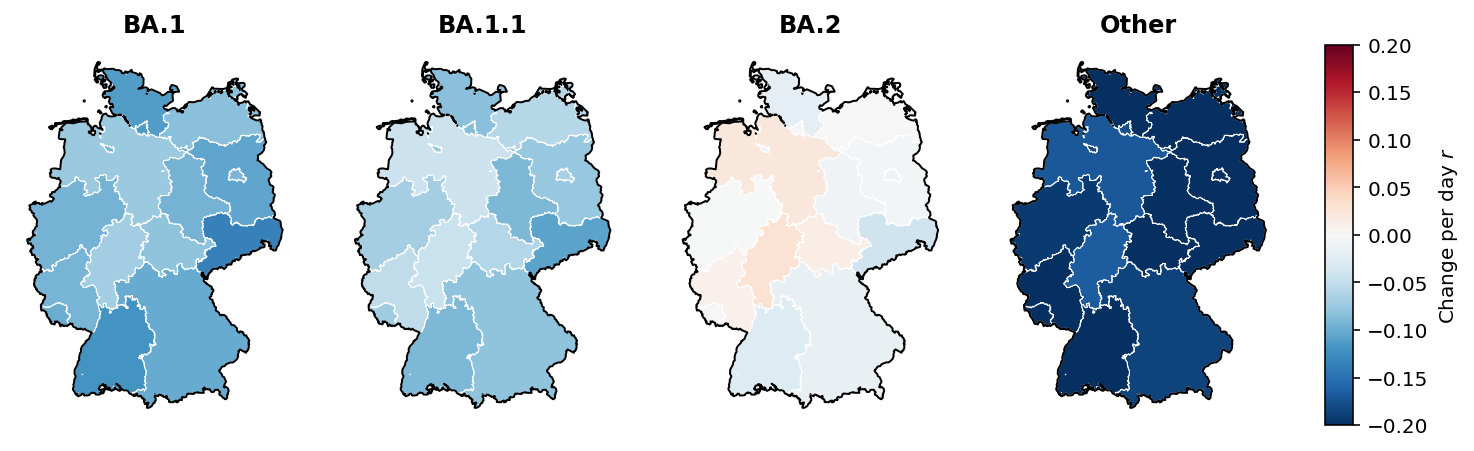

In [66]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
d = pd.DataFrame(r[:-1,:], columns=genomes.columns, index=bl.index)
#d.loc["Sachsen-Anhalt"]=np.nan
b0 = bl.copy().merge(d, 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="RdBu_r", vmin=-0.2,vmax=0.2, cax=axs[4], legend_kwds={'label': "Change per day $r$", 'pad':0.3}, legend=True, missing_kwds= dict(color = "lightgrey"))# norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#, norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
for i,ax in enumerate(axs[:-1]):
    ax.set_title(genomes.columns[[0,1,2,4]][i], weight='bold')
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [67]:
from sklearn.linear_model import LinearRegression as LR
from adjustText import adjust_text
import re

In [68]:
j

23

0.06930576814158232
0.0599543375641798
0.07756195945410835


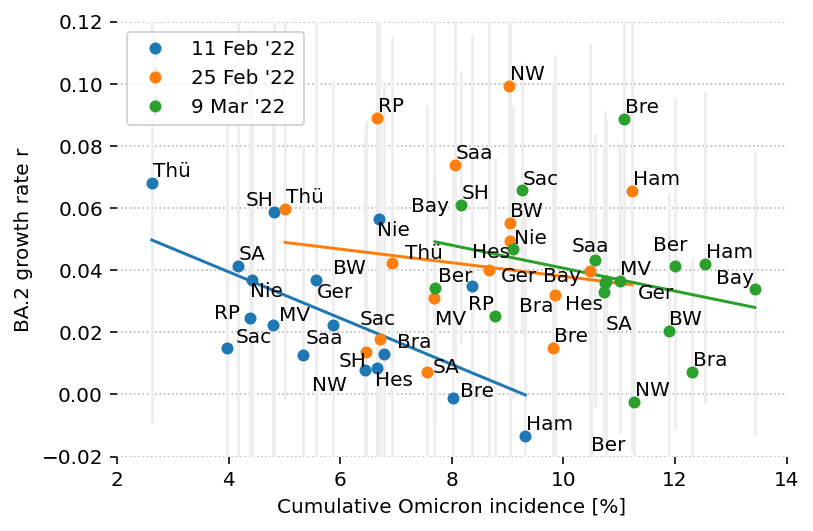

In [69]:
fig, axs = plt.subplots(1,1, figsize=(6,4), sharey=True)
#axs = axs.flatten()
text=[]
for k,l in enumerate(["2022-02-11", "2022-02-25","2022-03-09"]):
    j = np.where(cases_land.columns == l)[0][0]
    ax = axs#[0]
    ci = np.quantile(model.get_growth_rate_lineage(ltla=None)[:,:,j,2], (0.1, 0.9), axis=0)
    r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,j,:]

    lr = LR()
    x = λ[...,:j,:3].sum((1,2)) * 100
    y = r[:,2]
    lr.fit(x[:,np.newaxis], y)
    ax.errorbar(x, y, yerr=np.abs(ci - y[np.newaxis,:]), ls="", marker=".", ms=10,color=f'C{k}', ecolor='#EEEEEE', 
               label=cases_land.columns[j].strftime("%-d %b \'%y"))
    #ax.set_title(cases_land.columns[j].strftime("%-d %b \'%y"))

    l=[re.sub("[a-zöüä\-]","",x) if re.search("-",x) else x[:3] for x in (cases_land.index.to_list() + ['Germany'])]
    
    for i in range(x.shape[0]):
        if 1:#l[i]#in ["BW","NW","RP","Saa"]:
            text.append(ax.text(x[i], y[i], l[i], color='k', va='bottom', ha='center'))
    x.sort()
    y = lr.predict(x[:,np.newaxis])
    line = ax.plot(x, y, ls="-", c=f'C{k}')
    #plt.axline((0, lr.intercept_), slope=lr.coef_)
    #plt.scatter(λ[...,:2].sum((1,2)), r[:,2])
    ax.set_xlabel("Cumulative Omicron incidence [%]")
    if k == 0: 
        ax.set_ylabel("BA.2 growth rate r") 
    ax.set_ylim((-0.02,0.12))
    ax.set_xlim((2,14))
    print(lr.intercept_)

adjust_text(text,) 
                #add_objects=line, 
                #expand_objects = (1,1),
                #force_objects =  (0, 0.2),
                #only_move=dict(objects='y', text='y', points='y'),
                #arrowprops=dict(arrowstyle="-", color='grey', lw=0.5), )
ax.grid(axis='x', which='major')
ax.legend(loc='upper left')


In [70]:
λ[-1,-1,2]/ λ[-1,-1,:].sum()

0.8908873724746433

In [71]:
d = pd.DataFrame(model.get_growth_rate_lineage(ltla=None).mean(0)[:,[-24,-10],2], index=cases_land.index.to_list() + ["Germany"], columns=cases_land.columns[[-24,-10]])

<AxesSubplot:>

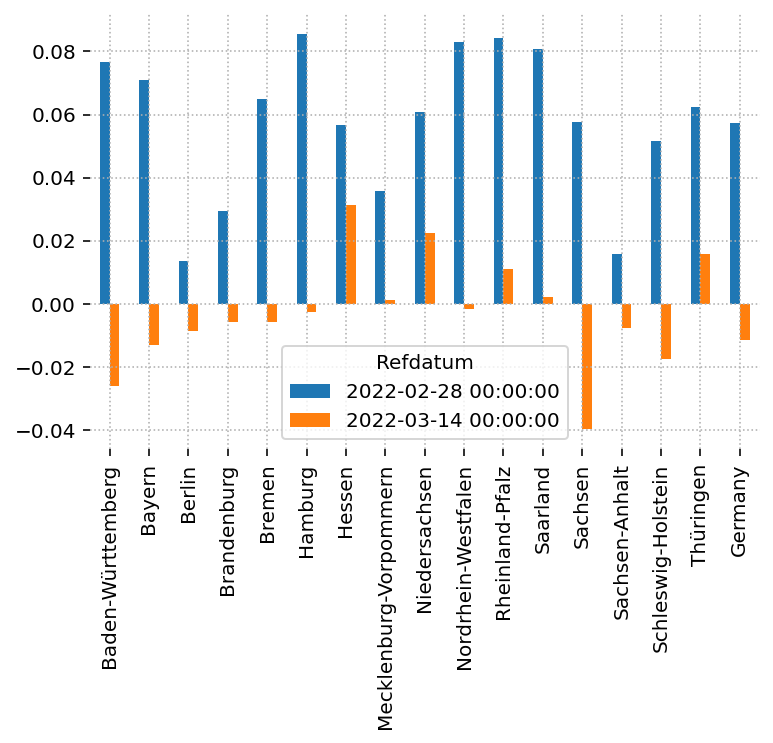

In [72]:
d.plot.bar()

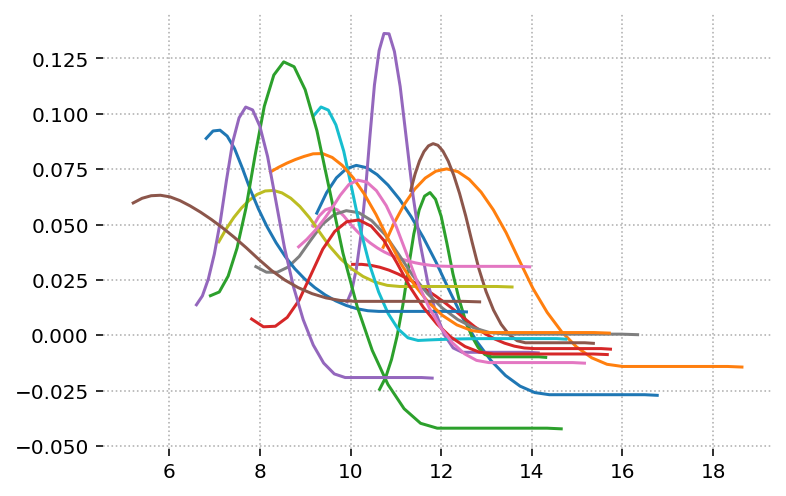

In [73]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-28:,2]
x = λ[...,:,:3].sum(2).cumsum(1)[:,-28:] * 100
for i in range(r.shape[0]):
    plt.plot(x[i,:],r[i,:])

(18962.0, 19070.0)

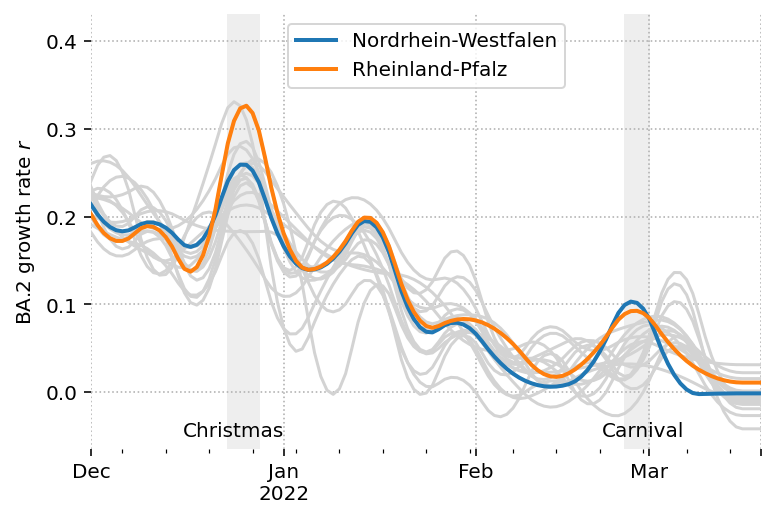

In [74]:
r = np.mean(model.get_growth_rate_lineage(ltla=None),0)[:,:,2]
r = pd.DataFrame(r.T[:-5], index=cases_land.columns[:-4].to_list(), columns=cases_land.index.to_list() + ["Germany"])
r.plot(c = 'lightgrey', alpha=1, legend=False)
r[["Nordrhein-Westfalen","Rheinland-Pfalz"]].plot( alpha=1, lw=2, ax=plt.gca())
#plt.legend("off")
plt.ylabel("BA.2 growth rate $r$")
plt.axvspan("2021-12-23","2021-12-28", color='#EEEEEE', zorder=0)
plt.axvspan("2022-02-25","2022-03-01", color='#EEEEEE', zorder=0)
plt.text("2021-12-24",-0.05,"Christmas", ha='center')
plt.text("2022-02-28",-0.05,"Carnival", ha='center')
plt.xlim(("2021-12-01",None))

In [64]:
from celluloid import Camera
from tqdm import tqdm
from matplotlib import colors


100%|██████████| 122/122 [00:42<00:00,  2.87it/s]


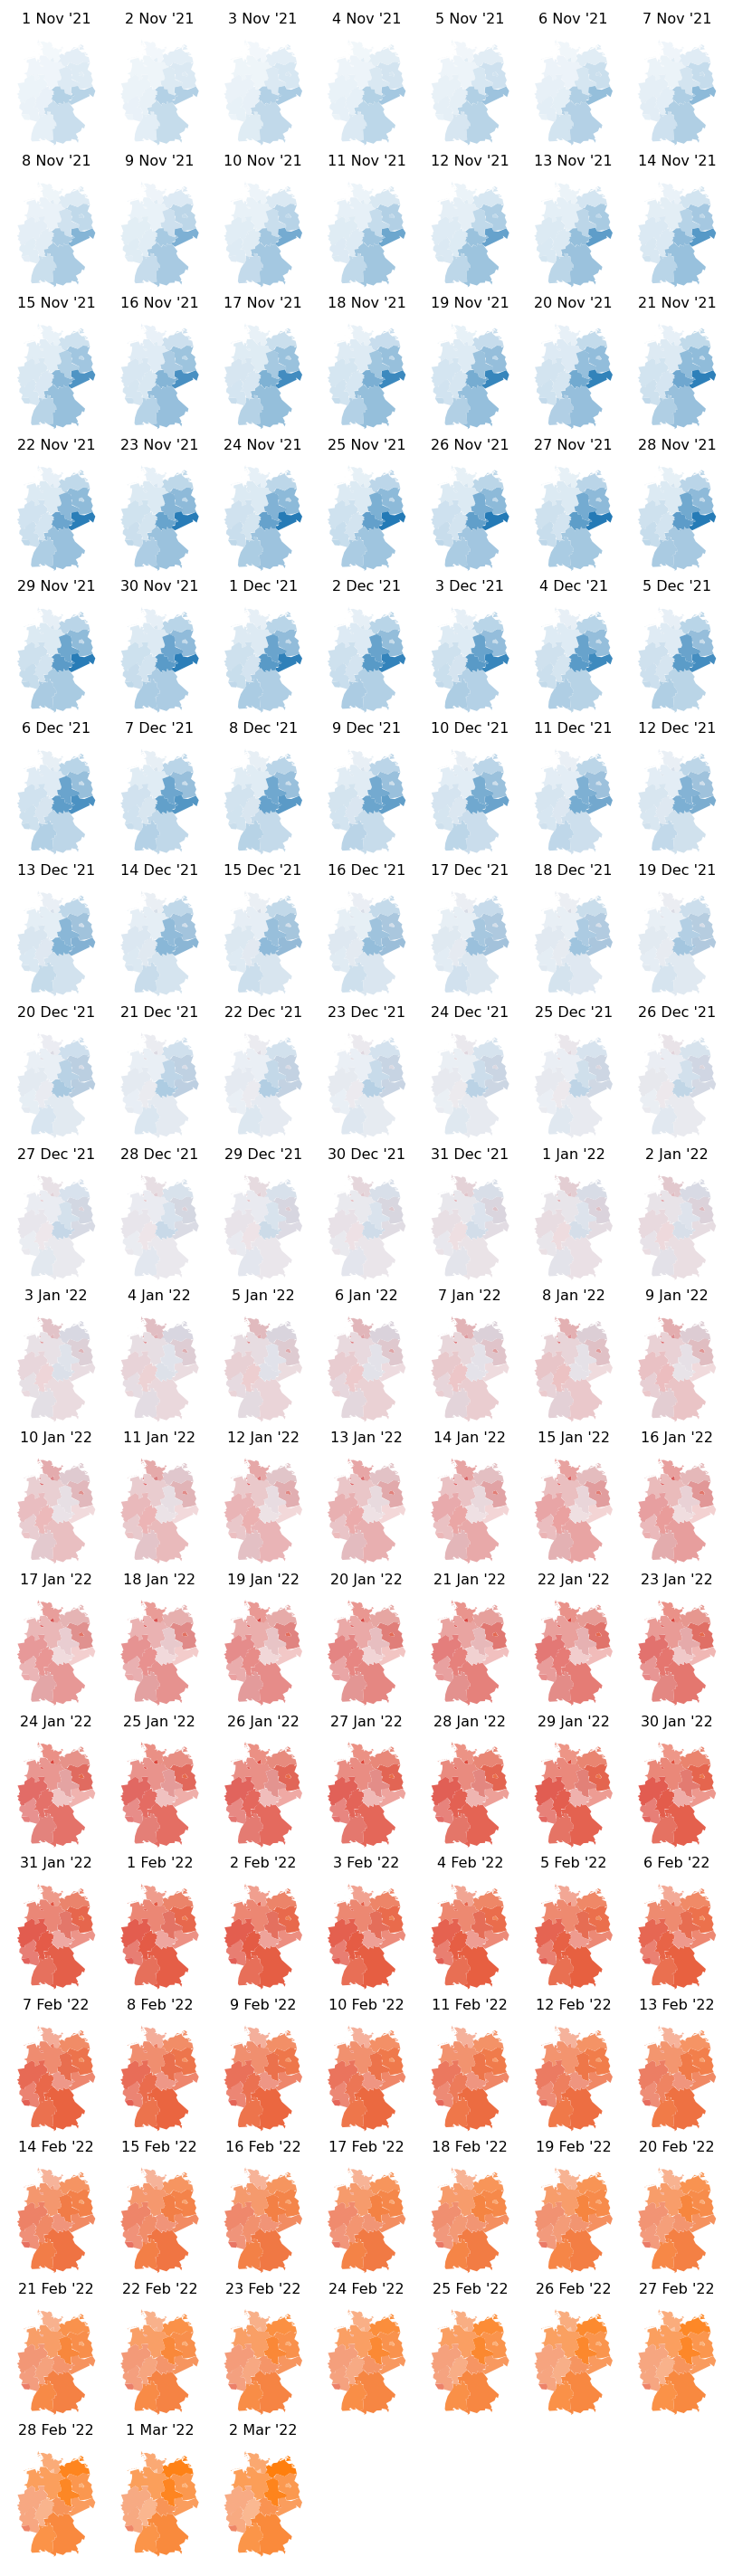

In [65]:
n = 7
m = (int(λ.shape[1]/7)+1)
fig, axs = plt.subplots(m,n, figsize=(7,10*m/n))
#camera = Camera(fig)
b0 = bl.copy().simplify(1e-1)
axs = axs.flatten()
for ax in axs:
    ax.axis("off")

    
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def alpha_to_color(alpha, c):
    c0 = []#(1,1,1)
    for x in alpha:
        cc = (1,1,1)
        for j, y in enumerate(x):
            cc = make_rgb_transparent(c[j ], cc, y)
        c0 += [cc]
    return c0

cols = [colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C1"),
     colors.colorConverter.to_rgb("C0")]

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    ax = axs[i]
        
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()

    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)

    ax.set_title((cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=8)
    b0.plot(color=c, ax=ax)

    #bl.boundary.plot(color='w',lw=0.5, ax=ax)
    #de.boundary.plot(color='k',lw=1, ax=ax)
    #camera.snap()


In [66]:
f"{λ[:-1,-1,1] @ capita.values:0.0f}"

'37221'

In [67]:
λ.max()*700

1.4526477300739673

100%|██████████| 122/122 [07:36<00:00,  3.74s/it]


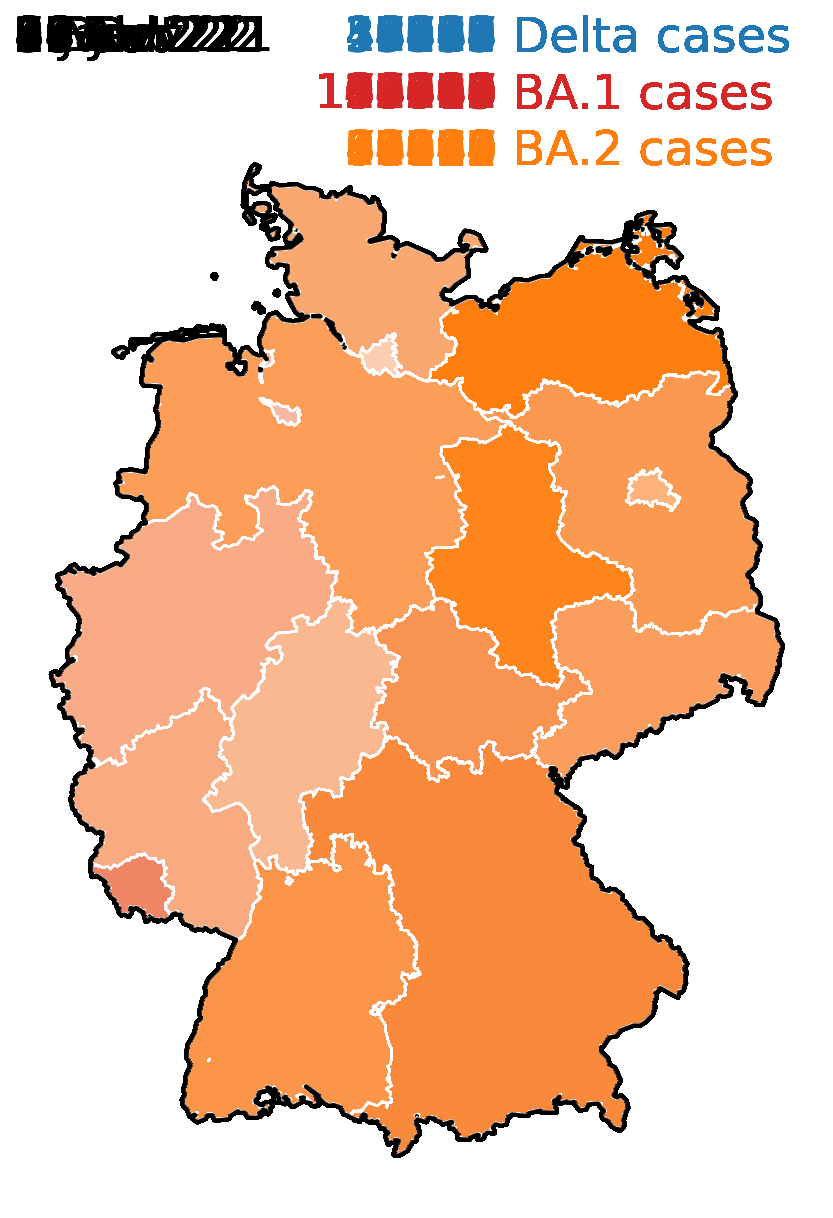

In [68]:
fig, ax = plt.subplots(1,1, figsize=(8,10.5), facecolor=None)
camera = Camera(fig)
b0 = bl.copy()#.simplify(1e-2)

ax.axis("off")

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()
    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)
    #c = [make_rgb_transparent(y, make_rgb_transparent(r, make_rgb_transparent(b, (1,1,1), x[2]), x[0]), x[1]) for x in alpha]
    b0.plot(color=c, ax=ax)

    #ax.set_title(cases_land.columns[i].strftime("%-d %b \'%y"), size=12)
    if i == 0:
        ax.set_ylim((None, ax.get_ylim()[0] + 1.05 * (ax.get_ylim()[1]-ax.get_ylim()[0])))
    
    ax.text(0.0, 1.01,  (cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=24, transform=ax.transAxes)
    ax.text(0.6, 1.01,  f"{λ[:-1,i,-1] @ capita.values:0.0f}", color = "C0", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 0.96,  f"{λ[:-1,i,[0,1]].sum(-1) @ capita.values:0.0f}", color = "C3", size=24, transform=ax.transAxes, ha= 'right')
    ax.text(0.6, 0.91,  f"{λ[:-1,i,2] @ capita.values:0.0f}", color = "C1", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 1.01,  f" Delta cases", color = "C0", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.96,  f" BA.1 cases", color = "C3", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.91,  f" BA.2 cases", color = "C1", size=24, transform=ax.transAxes)

    bl.boundary.plot(color='w',lw=1, ax=ax)
    de.boundary.plot(color='k',lw=2, ax=ax)
    camera.snap()


In [69]:
animation = camera.animate(interval = 100, blit=True, repeat = False, repeat_delay=1000)

In [70]:
#import ffmpeg
from IPython.display import HTML
import re
HTML(re.sub("width=\"576\"","width=288",animation.to_html5_video()))

# UK analysis

In [209]:
import requests
cases_uk = pd.read_csv("https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newCasesBySpecimenDate&format=csv", parse_dates=True, index_col=3)["newCasesBySpecimenDate"].sort_index().loc["2021-11-01":].iloc[:-1]

In [210]:
cases_uk

date
2021-11-01    45069
2021-11-02    37976
2021-11-03    35934
2021-11-04    33616
2021-11-05    30295
              ...  
2022-02-17    43559
2022-02-18    32333
2022-02-19    33861
2022-02-20    36757
2022-02-21    42078
Name: newCasesBySpecimenDate, Length: 113, dtype: int64

In [211]:
x = []
c = "United Kingdom"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])

genomes_uk = pd.DataFrame(x).T.fillna(0)#
genomes_uk = genomes_uk.loc[genomes_uk.index <= cases_uk.index.max(),:]
genomes_uk.sum(0)

BA.1          338473.0
BA.1.1        138324.0
BA.2           29613.0
BA.3              18.0
B.1.617.2*    372938.0
dtype: float64

In [212]:
genomes_uk = genomes_uk[genomes_uk.sum(1) > 100]

In [213]:
genomes_uk

BA.1  BA.1.1    BA.2  BA.3  B.1.617.2*
date                                                
2021-11-01     0.0     0.0     0.0   0.0      7781.0
2021-11-02     0.0     0.0     0.0   0.0      5999.0
2021-11-03     1.0     0.0     0.0   0.0      7031.0
2021-11-04     0.0     0.0     0.0   0.0      6415.0
2021-11-05     0.0     0.0     0.0   0.0      7034.0
...            ...     ...     ...   ...         ...
2022-02-12  1279.0  1889.0  1444.0   1.0         1.0
2022-02-13   635.0   983.0   856.0   0.0         1.0
2022-02-14   764.0  1270.0  1026.0   0.0         0.0
2022-02-15   368.0   617.0   593.0   0.0         1.0
2022-02-16    30.0    57.0    72.0   0.0         0.0

[108 rows x 5 columns]

In [214]:
genomes_uk["BA.1"][:"2021-11-18"] = 0
genomes_uk["BA.1.1"][:"2021-11-18"] = 0
genomes_uk["BA.2"][:"2021-12-18"] = 0

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,8,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]
#bar[1,genomes_uk.index > d[1],:] = 0
#bar[2,genomes_uk.index <= d[1],:] = 0

In [216]:
date_split

array(['2021-12-14', '2021-12-28', '2022-01-11', '2022-01-25'],
      dtype='datetime64[D]')

In [217]:
foo = np.stack((len(date_split)+1) * [cases_uk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_uk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_uk.index > dd,:] = 0
    bar[i+1,genomes_uk.index <= dd,:] = 0


In [218]:
model_uk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]),
    np.repeat(67.22e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=10.,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [219]:
model_uk.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


KeyboardInterrupt: 

In [ ]:
plt.plot(model_uk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,4]#np.arange(genomes_uk.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_uk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_uk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right= 5 if j == 0 else 1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("United Kingdom", size=12, weight='bold')
#ax[0].set_yscale("log")

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.2,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
#f = ax[2].xaxis.get_major_formatter()
#ax[1].xaxis.set_major_formatter(f)
#ax[1].set_xticklabels(ax[2].get_xticklabels(), visible=True)
#plt.setp(ax[1].get_xticklabels(),visible=True)
#plt.delaxes(ax[3])
#plt.delaxes(ax[0])
#ax[1].xaxis.set_tick_params(labelbottom=True)

#ax[1].xaxis.set_major_formatter(f)


In [ ]:
## import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_uk, genomes_uk.columns.to_list(), color=["C0","None"], baseline="BA.1")


In [ ]:
bar.shape

In [ ]:
ax=plt.gcf().get_axes()

In [ ]:
ax

## Germany

In [358]:
foo = np.stack((len(date_split)+1) * [CC[-1]], axis=0)
bar = np.stack((len(date_split)+1)  * [GG[-1]], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes.index.levels[1] > dd + np.timedelta64(2,"D"),:] = 0
    bar[i+1,genomes.index.levels[1] < dd - np.timedelta64(1,"D"),:] = 0
bar[0,:,2] = 0

In [359]:
model_de = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    seq_index,
    np.repeat(capita.values.sum().reshape(1),len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [360]:
model_de.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

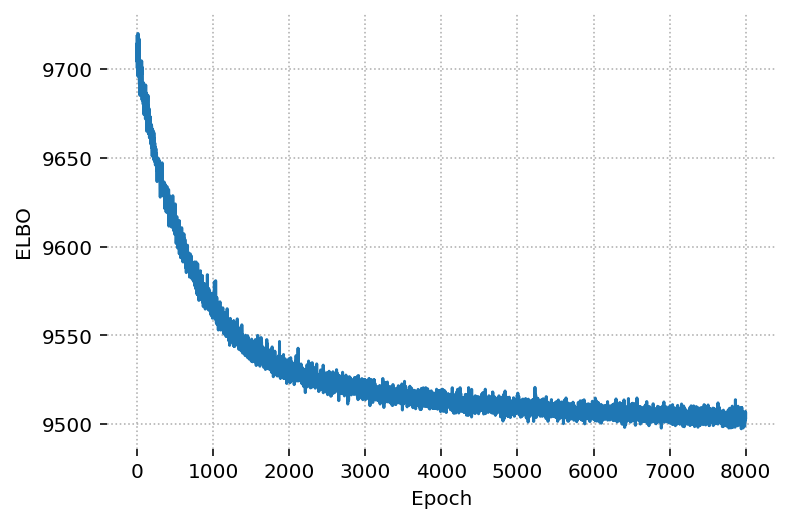

In [361]:
plt.plot(model_de.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [362]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

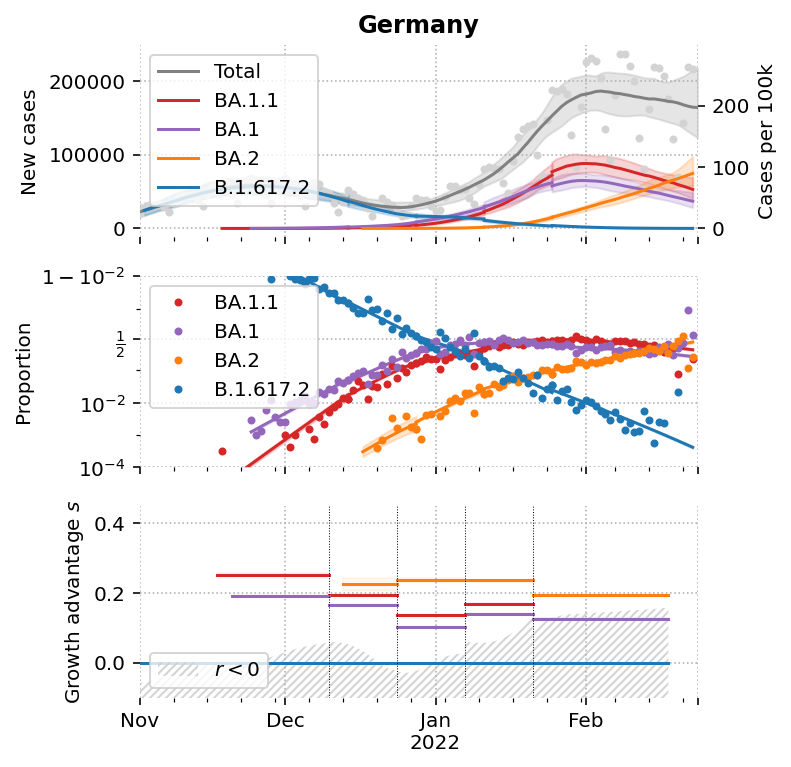

In [363]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [1,0,2,5]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_de, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C4','C3', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = -1,
             bleed_right= 5 if j == 0 else -1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Germany", size=12, weight='bold')

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])



In [364]:
pd.DataFrame(get_transmissibility(model_de), columns=genomes.columns)

lineage      BA.1    BA.1.1      BA.2      BA.3     Other  B.1.617.2
0        0.191420  0.252462  0.021681  0.042103  0.074427        0.0
1        0.165376  0.194052  0.223760  0.042103  0.086572        0.0
2        0.102504  0.135664  0.237153  0.133593  0.063556        0.0
3        0.140669  0.169088  0.236354 -0.056527 -0.127477        0.0
4        0.124018  0.126526  0.194083  0.188843  0.192795        0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1        64760                   0.018187  0.031125   
BA.1.1      62333                   0.018127  0.045396   
BA.2        14991                   0.021681  0.017539   
BA.3           25                   0.042103  0.110309   
Other         274                   0.031535  0.103882   
B.1.617.2  137593                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.031125  
BA.1.1                           0.030761  0.045396  
BA.2                             0.078040  0.017539  
BA.3                            -0.056161  0.110309  
Other                           -0.086823  0.103882  
B.1.617.2                       -0.144798  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:876: RuntimeWarning: divide by zero encountered in log
  ax3.set_ylabel("Approximate $R_t$ ratio")


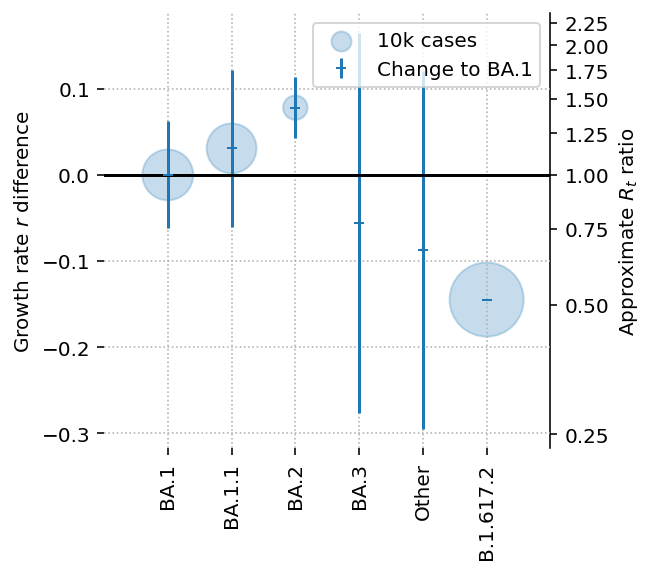

In [365]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_de, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")


## Denmark

In [ ]:
cases_dk = pd.read_csv("../overvaagningsdata-dashboard-covid19-31012022-40ip/Regionalt_DB/08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv", index_col=[0,1],parse_dates=True, encoding='latin_1', sep=";").sum(level=1).loc["2021-11-01":].iloc[:-1,0]

In [ ]:
cases_dk

In [ ]:
x = []
c = "Denmark"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    try:
        x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])
    except:
        pass


genomes_dk = pd.DataFrame(x).T.fillna(0)#
genomes_dk = genomes_dk.loc[genomes_dk.index <= cases_dk.index.max(),:]
genomes_dk.sum(0)

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,6,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]

In [ ]:
foo = np.stack((len(date_split)+1) * [cases_dk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_dk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_dk.index > dd,:] = 0
    bar[i+1,genomes_dk.index <= dd,:] = 0


In [ ]:
model_dk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_dk.index.to_list().index(i) for i in genomes_dk.index]),
    np.repeat(5.831e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.1,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':12000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [ ]:
foo.shape

In [ ]:
model_dk.fit()

In [ ]:
plt.plot(model_dk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,3]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_dk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_dk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C0", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right=3 if j ==0 else 1,
             show_Rt = False,
             plot_s= True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Denmark", size=12, weight='bold')

#ax[1].set_yscale("logit")
#ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend().remove()
ax[1].legend(facecolor='white')
ax[2].legend(loc='lower right')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])


In [ ]:
(bar[-1,-15:] )

In [ ]:
genomes_dk

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_dk, genomes_dk.columns.to_list(), color=["C0","None"], baseline="BA.1")
